# Worldwide Population Aging and Birth Rate Prediction

Project for CIS 545 Big Data Analytics, spring 2022.

- **Team members**: Sisun Cheng, Shimin Tu, Lan Xiao.
- **Instructors**: Profs. Susan Davidson and Zachary Ives
- **Assigned TA** (with many thanks): Carol Li.

We have a **recording** to help you walk through our project. Please find the link [here](https://drive.google.com/drive/folders/137Qk8tUgHyXBa1AR-ojjAAKCFmAgAHln?usp=sharing)!

# 0.Introduction

Nowadays, a lot of countries, especially developed countries, are facing the problem of high aging level, while some developing countries are suffering from high birth rates. We will explore the contributing factors of population aging, which will be used to classify the future **aging** situation 20 years from now. Since population aging is to some extent related to low birth rates, we are also going to predict the **birth rate** in future 20 years with its time pattern.  

To give a general overview of our project, we select the Health, Nutrition, and Population Statistics dataset from Kaggle datasets. There are two main parts in our project, the first part focus on **aging level prediction** with multiple features extracted from the dataset and the second part focus on time series **prediction for birth rate** in 20 years.

In [ ]:
!pip install geopandas
!pip install hvplot
!pip install altair
!pip install impyute
!pip install pmdarima

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv 
import hvplot.pandas
import altair as alt
import panel as pn
pn.extension()
import warnings
warnings.filterwarnings('ignore')
import sys
from impyute.imputation.cs import fast_knn

import os
import statsmodels.api as sm

In [ ]:
pd.options.display.max_columns = None

# 1.Classification Prediction for Aging in 20 Years

In this part, we'd like to explore the relationship between different health and population indicators and **aging level** of each country. Our unit of analysis is country and we aim to build up **classification** models to predict the aging level of countries in 2038 based on indicators of 2018, before which we would train the model first with aging level in 2018 and indicators of 1998.


## 1.1 Data Loading and Preprocessing




First, we load the `Health Nutrition and Population Statistics` data from our Github Repository in .csv format. Here we also load the `world country` data with geometry from GeoPandas dataset for visualization.

In [ ]:
url1 = 'https://raw.githubusercontent.com/keeea/Worldwide-Population-Aging-and-Birth-Rate/main/data/hnp_stats_csv/HNP_StatsData.csv'
Data = pd.read_csv(url1)
world_gpd = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
Data.head()

Country Name Country Code  \
0  Africa Eastern and Southern          AFE   
1  Africa Eastern and Southern          AFE   
2  Africa Eastern and Southern          AFE   
3  Africa Eastern and Southern          AFE   
4  Africa Eastern and Southern          AFE   

                                      Indicator Name  Indicator Code  \
0  Adolescent fertility rate (births per 1,000 wo...     SP.ADO.TFRT   
1  Adults (ages 15+) and children (0-14 years) li...     SH.HIV.TOTL   
2  Adults (ages 15+) and children (ages 0-14) new...  SH.HIV.INCD.TL   
3                  Adults (ages 15+) living with HIV     SH.DYN.AIDS   
4        Adults (ages 15-49) newly infected with HIV     SH.HIV.INCD   

         1960        1961        1962       1963       1964        1965  \
0  140.120535  140.594564  141.128109  141.32344  141.50816  141.668896   
1         NaN         NaN         NaN        NaN        NaN         NaN   
2         NaN         NaN         NaN        NaN        NaN         NaN   
3         NaN         NaN         NaN        NaN        NaN         NaN   
4         NaN         NaN         NaN        NaN        NaN         NaN   

         1966        1967        1968        1969        1970        1971  \
0  141.879704  141.983225  142.020168  142.010506  142.033458  142.279778   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

         1972        1973        1974        1975        1976        1977  \
0  142.629356  142.469778  142.290486  142.053901  141.730609  141.396423   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

         1978        1979        1980        1981        1982        1983  \
0  140.774087  140.150094  139.513693  138.804554  138.071244  137.058143   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

         1984       1985        1986        1987        1988        1989  \
0  136.059339  135.08785  134.103381  133.152267  132.012111  130.869067   
1         NaN        NaN         NaN         NaN         NaN         NaN   
2         NaN        NaN         NaN         NaN         NaN         NaN   
3         NaN        NaN         NaN         NaN         NaN         NaN   
4         NaN        NaN         NaN         NaN         NaN         NaN   

         1990        1991        1992        1993        1994        1995  \
0  129.717498  128.562197  127.400373  126.969852  126.495358  125.972751   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

         1996        1997        1998        1999        2000        2001  \
0  125.398693  124.772067  123.657335  122.560576  121.519841  120.546675   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

         2002        2003        2004        2005        2006        2007  \
0 

We get the list of indicators here with `unique()` function. There are 441 health and social wellness related indicators in total in our dataset. So our first task is to apply dimensionality reduction on those indicators.

In [ ]:
indicator_list = Data['Indicator Name'].unique()
len(indicator_list)

441

### 1.1.1 Dimensionality Reduction - Missing Values Ratio

For the first round of dimensionality reduction, we want to filter out those indicators with too many missing values. Since we'll take use of the indicators of the years 1998 and 2018, we filter the indicators for which more than 150 countries have a valid score in both years. The filtered indicators are stored in *select_indicator_1* list and there are 211 indicators in the list which meet our basic requirement.


In [ ]:
select_indicator_1 = []
for i in indicator_list:
  describe = Data[Data['Indicator Name'] == i].describe()
  indicator_count_2018 = describe[['2018']].loc['count'].item()
  indicator_count_1998 = describe[['1998']].loc['count'].item()
  if (indicator_count_2018 > 150) & (indicator_count_1998 > 150):
    # print(i, '-2018:', indicator_count)
    select_indicator_1.append(i)

In [ ]:
# select_indicator_1
len(select_indicator_1)

211

### 1.1.2 Dimensionality Reduction - Data Leak

Based on *select_indicator_1*, we manually select some features, *obtaining select_indicator_2*. For this process, we mainly get rid of the indicators with a risk of data leakage, that is to say, we remove the indicators that reveal the aging level to some extent, for example `population of a given age range in percentage`. There are 62 indicators left after our manual reduction.

In [ ]:
select_indicator_2 = ['Country Code',
'Adolescent fertility rate (births per 1,000 women ages 15-19)',
'Birth rate, crude (per 1,000 people)',
'Death rate, crude (per 1,000 people)',
'Fertility rate, total (births per woman)',
'GNI per capita, Atlas method (current US$)',
'Immunization, BCG (% of one-year-old children)',
'Immunization, DPT (% of children ages 12-23 months)',
'Immunization, Pol3 (% of one-year-old children)',
'Immunization, measles (% of children ages 12-23 months)',
'Incidence of HIV, all (per 1,000 uninfected population)',
'Labor force, female (% of total labor force)',
'Labor force, total',
'Life expectancy at birth, female (years)',
'Life expectancy at birth, male (years)',
'Life expectancy at birth, total (years)',
'Mortality rate, adult, female (per 1,000 female adults)',
'Mortality rate, adult, male (per 1,000 male adults)',
'Mortality rate, infant (per 1,000 live births)',
'Mortality rate, infant, female (per 1,000 live births)',
'Mortality rate, infant, male (per 1,000 live births)',
'Mortality rate, neonatal (per 1,000 live births)',
'Mortality rate, under-5 (per 1,000)',
'Mortality rate, under-5, female (per 1,000)',
'Mortality rate, under-5, male (per 1,000)',
'Number of infant deaths',
'Number of infant deaths, female',
'Number of infant deaths, male',
'Number of neonatal deaths',
'Number of under-five deaths',
'Number of under-five deaths, female',
'Number of under-five deaths, male',
#'Population growth (annual %)',
'Population, female',
'Population, female (% of total population)',
'Population, male',
'Population, male (% of total population)',
'Population, total',
'Prevalence of HIV, female (% ages 15-24)',
'Prevalence of HIV, male (% ages 15-24)',
'Prevalence of HIV, total (% of population ages 15-49)',
'Prevalence of hypertension (% of adults ages 30-79)',
'Prevalence of hypertension, female (% of female adults ages 30-79)',
'Prevalence of hypertension, male (% of male adults ages 30-79)',
'Probability of dying among adolescents ages 10-14 years (per 1,000)',
'Probability of dying among adolescents ages 10-19 years (per 1,000)',
'Probability of dying among adolescents ages 15-19 years (per 1,000)',
'Probability of dying among children ages 5-9 years (per 1,000)',
'Probability of dying among youth ages 20-24 years (per 1,000)',
'Rural population',
'Rural population (% of total population)',
#'Rural population growth (annual %)',
'School enrollment, primary (% gross)',
'School enrollment, primary, female (% gross)',
'School enrollment, primary, male (% gross)',
'Treatment for hypertension (% of adults ages 30-79 with hypertension)',
'Treatment for hypertension, female (% of female adults ages 30-79 with hypertension)',
'Treatment for hypertension, male (% of male adults ages 30-79 with hypertension)',
'Unemployment, female (% of female labor force)',
'Unemployment, male (% of male labor force)',
'Unemployment, total (% of total labor force)',
'Urban population',
'Urban population (% of total population)',
#'Urban population growth (annual %)',
'Population ages 65 and above (% of total population)'
]

In [ ]:
len(select_indicator_2)

62

In [ ]:
indicators_1998 = Data[['Country Code','Indicator Name','1998']][Data['Indicator Name'].isin(select_indicator_2)]
indicators_1998 = indicators_1998.pivot(index='Country Code', columns='Indicator Name', values='1998').reset_index()
indicators_1998.head()

#indicators_1998 = indicators_1998.fillna(0)

Indicator Name Country Code  \
0                       ABW   
1                       AFE   
2                       AFG   
3                       AFW   
4                       AGO   

Indicator Name  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                       46.067000               
1                                                      123.657335               
2                                                      161.469000               
3                                                      141.275143               
4                                                      200.566400               

Indicator Name  Birth rate, crude (per 1,000 people)  \
0                                           15.09000   
1                                           41.11069   
2                                           48.68800   
3                                           43.33699   
4                                           48.46000   

Indicator Name  Death rate, crude (per 1,000 people)  \
0                                           6.915000   
1                                          14.661901   
2                                          12.348000   
3                                          16.439772   
4                                          18.706000   

Indicator Name  Fertility rate, total (births per woman)  \
0                                               1.939000   
1                                               5.684033   
2                                               7.610000   
3                                               6.116602   
4                                               6.732000   

Indicator Name  GNI per capita, Atlas method (current US$)  \
0                                             17620.000000   
1                                               693.264194   
2                                                      NaN   
3                                               463.578133   
4                                               410.000000   

Indicator Name  Immunization, BCG (% of one-year-old children)  \
0                                                          NaN   
1                                                    68.979823   
2                                                    35.000000   
3                                                    60.395645   
4                                                    60.000000   

Indicator Name  Immunization, DPT (% of children ages 12-23 months)  \
0                                                             NaN     
1                                                       55.542022     
2                                                       27.000000     
3                                                       40.507010     
4                                                       47.000000     

Indicator Name  Immunization, Pol3 (% of one-year-old children)  \
0                                                           NaN   
1                                                     60.526125   
2                                                     28.000000   
3                                                     36.181280   
4                                                     43.000000   

Indicator Name  Immunization, measles (% of children ages 12-23 months)  \
0                                                             NaN         
1                                                       57.119956         
2                                                       31.000000         
3                                                       43.829768         
4                                                       59.000000         

Indicator Name  Incidence of HIV, all (per 1,000 uninfected population)  \
0                                                             NaN         
1                                                        4.696028         
2              

### 1.1.3 Dimensionality Reduction - High Correlation

For the next step, we take a look at the feature correlations. Correlation is scale sensitive; therefore column normalization is required for a meaningful correlation comparison.

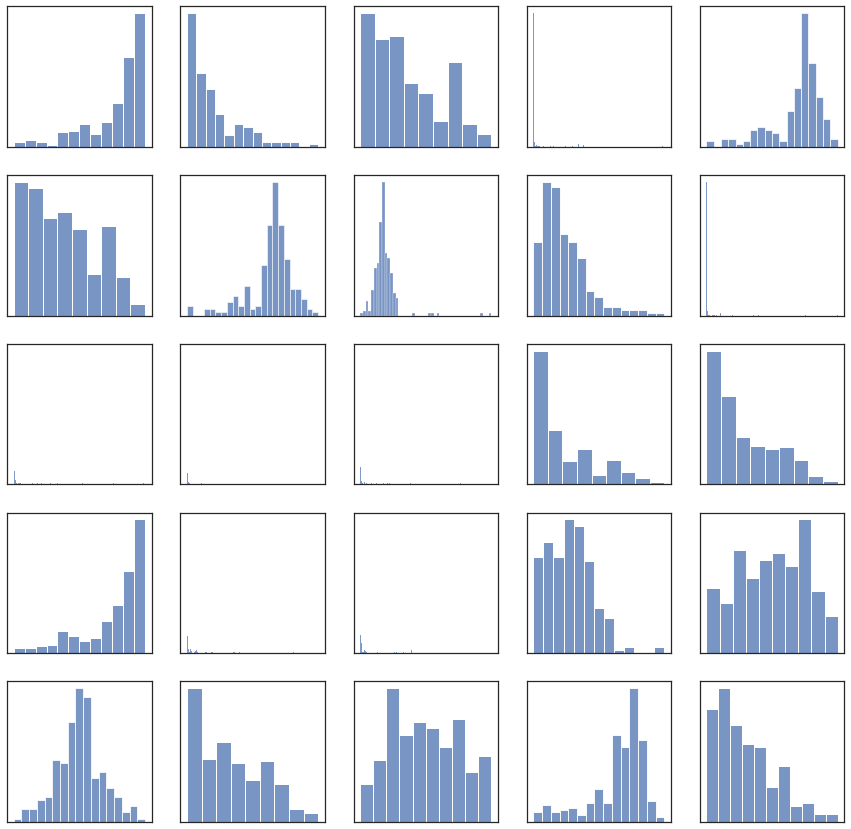

In [ ]:
import random
random_indicators = random.sample(select_indicator_2[1:61], 25)
indicators_1998_num = indicators_1998.drop(columns='Country Code')

sns.set(style="white")

ncols = 5
nrows = 5

# create the plots
fig = plt.figure(figsize=(15, 15))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

indicator_list = []
# add some data
for i,axi in enumerate(axes):
  sns.histplot(data=indicators_1998_num[random_indicators[i]], ax=axi)

# remove the x and y ticks
for axi in axes:
  axi.get_xaxis().set_visible(False)
  axi.get_yaxis().set_visible(False)

As diagrams show above, most variables in this data are not normal distribution, so **Min-Max Scaling** will be applied here.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
indicators_1998_num[indicators_1998_num.columns] = min_max_scaler.fit_transform(indicators_1998_num)
indicators_1998_num

Indicator Name  Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                                        0.206260               
1                                                        0.562864               
2                                                        0.736646               
3                                                        0.643835               
4                                                        0.916337               
..                                                            ...               
261                                                           NaN               
262                                                      0.482456               
263                                                      0.338396               
264                                                      0.730801               
265                                                      0.454745               

Indicator Name  Birth rate, crude (per 1,000 people)  \
0                                           0.161158   
1                                           0.721032   
2                                           0.884069   
3                                           0.768934   
4                                           0.879163   
..                                               ...   
261                                         0.294776   
262                                         0.732055   
263                                         0.342091   
264                                         0.811989   
265                                         0.520053   

Indicator Name  Death rate, crude (per 1,000 people)  \
0                                           0.214183   
1                                           0.550406   
2                                           0.449980   
3                                           0.627567   
4                                           0.725923   
..                                               ...   
261                                         0.200512   
262                                         0.330281   
263                                         0.381364   
264                                         0.718632   
265                                         0.573630   

Indicator Name  Fertility rate, total (births per woman)  \
0                                               0.138132   
1                                               0.698598   
2                                               0.986830   
3                                               0.763335   
4                                               0.855433   
..                                                   ...   
261                                             0.234062   
262                                             0.856330   
263                                             0.271326   
264                                             0.759802   
265                                             0.422478   

Indicator Name  GNI per capita, Atlas method (current US$)  \
0                                                 0.225690   
1                                                 0.007393   
2                                                      NaN   
3                                                 0.004431   
4                                                 0.003740   
..                                                     ...   
261                                                    NaN   
262                                               0.003224   
263                                               0.044751   
264                                               0.003095   
265                                               0.006448   

Indicator Name  Immunization, BCG (% of one-year-old children)  \
0                                                          NaN   
1                                                     0.638311   
2                

Explore feature correlations with correlation matrix.

In [ ]:
corr_matrix = indicators_1998_num.corr()

In [ ]:
corr_matrix.head()

Indicator Name                                      Adolescent fertility rate (births per 1,000 women ages 15-19)  \
Indicator Name                                                                                                      
Adolescent fertility rate (births per 1,000 wom...                                           1.000000               
Birth rate, crude (per 1,000 people)                                                         0.860354               
Death rate, crude (per 1,000 people)                                                         0.589395               
Fertility rate, total (births per woman)                                                     0.833942               
GNI per capita, Atlas method (current US$)                                                  -0.513991               

Indicator Name                                      Birth rate, crude (per 1,000 people)  \
Indicator Name                                                                             
Adolescent fertility rate (births per 1,000 wom...                              0.860354   
Birth rate, crude (per 1,000 people)                                            1.000000   
Death rate, crude (per 1,000 people)                                            0.502659   
Fertility rate, total (births per woman)                                        0.985961   
GNI per capita, Atlas method (current US$)                                     -0.511381   

Indicator Name                                      Death rate, crude (per 1,000 people)  \
Indicator Name                                                                             
Adolescent fertility rate (births per 1,000 wom...                              0.589395   
Birth rate, crude (per 1,000 people)                                            0.502659   
Death rate, crude (per 1,000 people)                                            1.000000   
Fertility rate, total (births per woman)                                        0.547248   
GNI per capita, Atlas method (current US$)                                     -0.209617   

Indicator Name                                      Fertility rate, total (births per woman)  \
Indicator Name                                                                                 
Adolescent fertility rate (births per 1,000 wom...                                  0.833942   
Birth rate, crude (per 1,000 people)                                                0.985961   
Death rate, crude (per 1,000 people)                                                0.547248   
Fertility rate, total (births per woman)                                            1.000000   
GNI per capita, Atlas method (current US$)                                         -0.501596   

Indicator Name                                      GNI per capita, Atlas method (current US$)  \
Indicator Name                                                                                   
Adolescent fertility rate (births per 1,000 wom...                                   -0.513991   
Birth rate, crude (per 1,000 people)                                                 -0.511381   
Death rate, crude (per 1,000 people)                                                 -0.209617   
Fertility rate, total (births per woman)                                             -0.501596   
GNI per capita, Atlas method (current US$)                                            1.000000   

Indicator Name                                      Immunization, BCG (% of one-year-old children)  \
Indicator Name                                                                                       
Adolescent fertility rate (births per 1,000 wom...                                       -0.431977   
Birth rate, crude (per 1,000 people)                                                     -0.535399   
Death rate, crude (per 1,000 people)                                                     -0.421877   
Fertility rate, tota

In [ ]:
#corr_matrix.to_csv('corr.csv', index=True)

Text(0.5, 1.05, 'Correlation Heatmap')

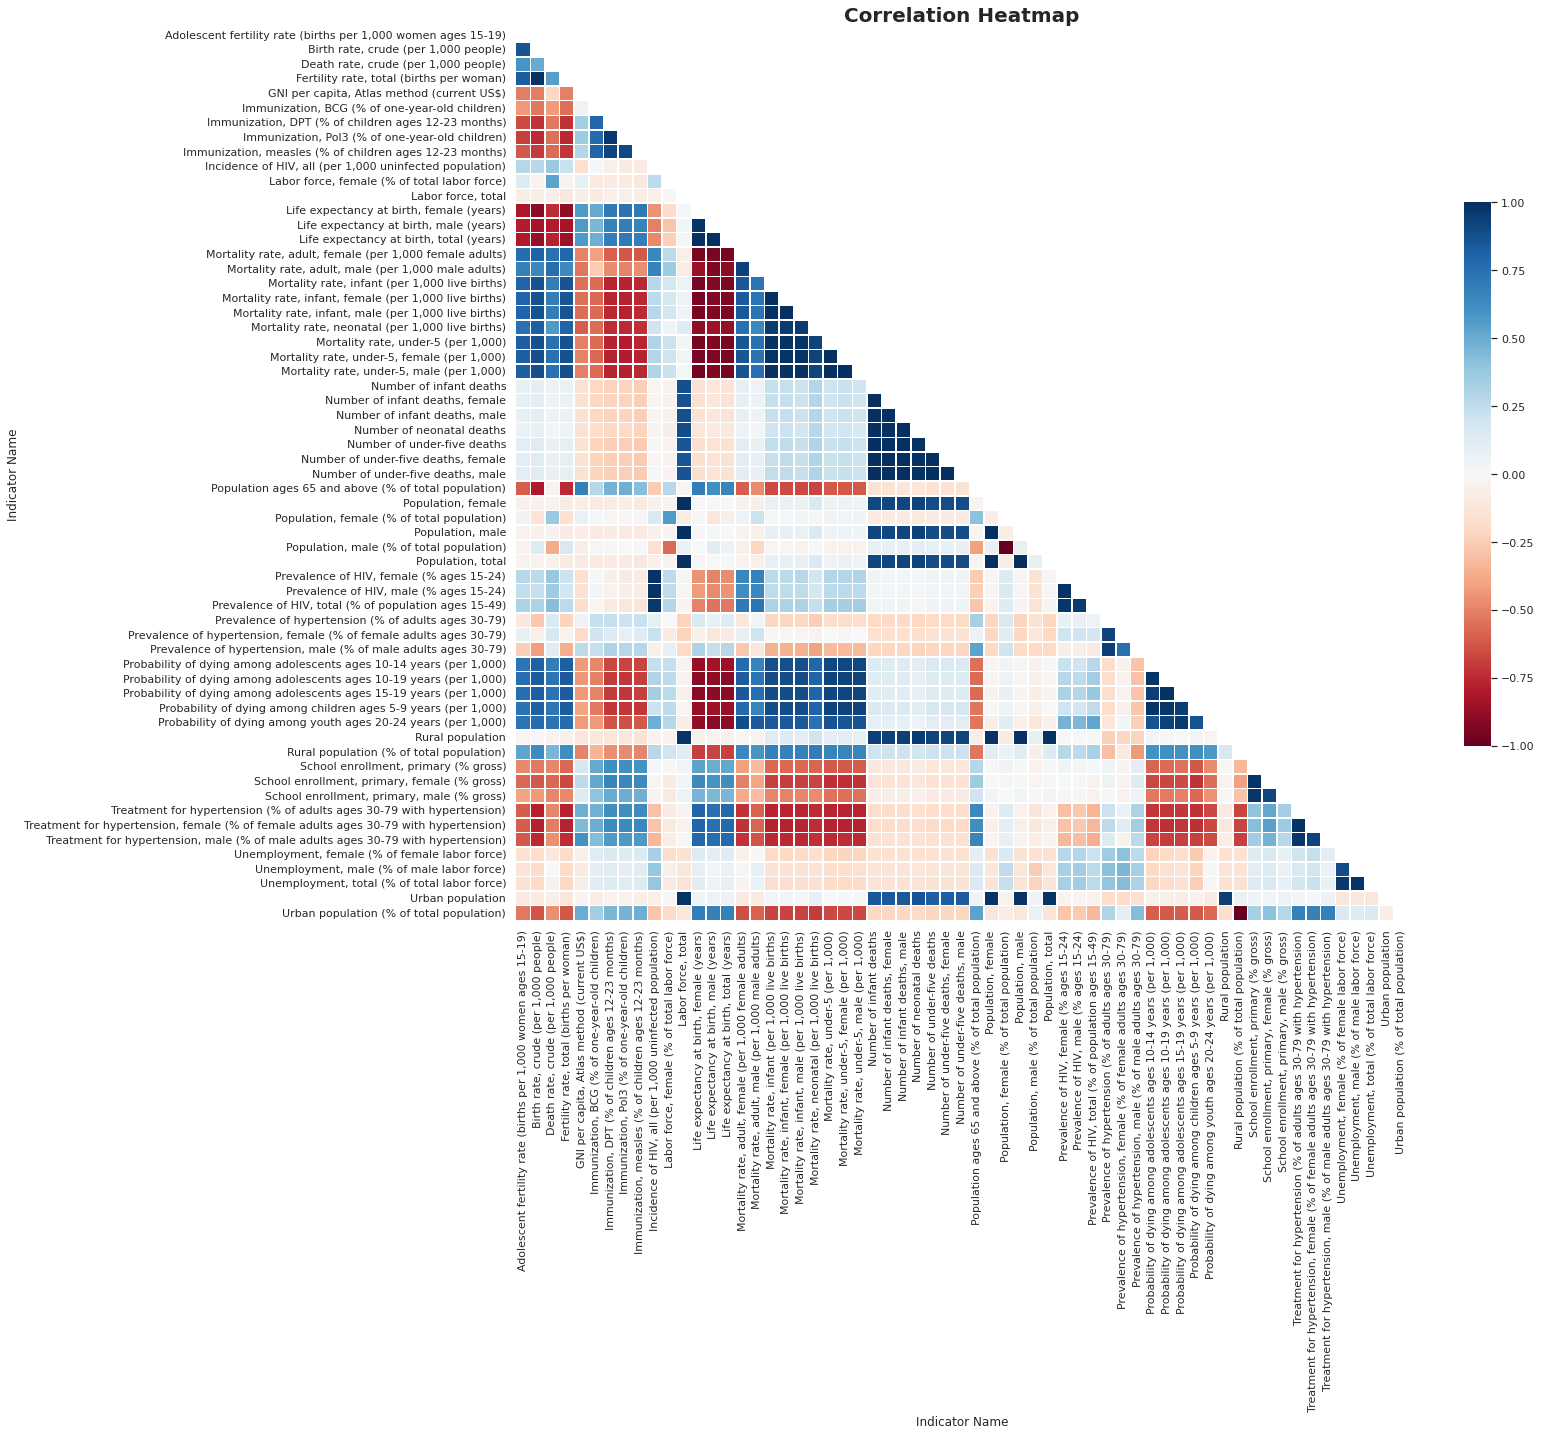

In [ ]:
sns.set(style = "white")

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("RdBu", as_cmap=True)

sns.heatmap(corr_matrix, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin=-1,
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
ax.set_title('Correlation Heatmap',
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)


There are still some features correlated with each other, and we decide to remove some of those features. Although many of the machine learning models tolerates multi-collinearity, we have no idea which specific model we’ll apply in this stage. Thus, a safe method is to take away some of the correlated features now.

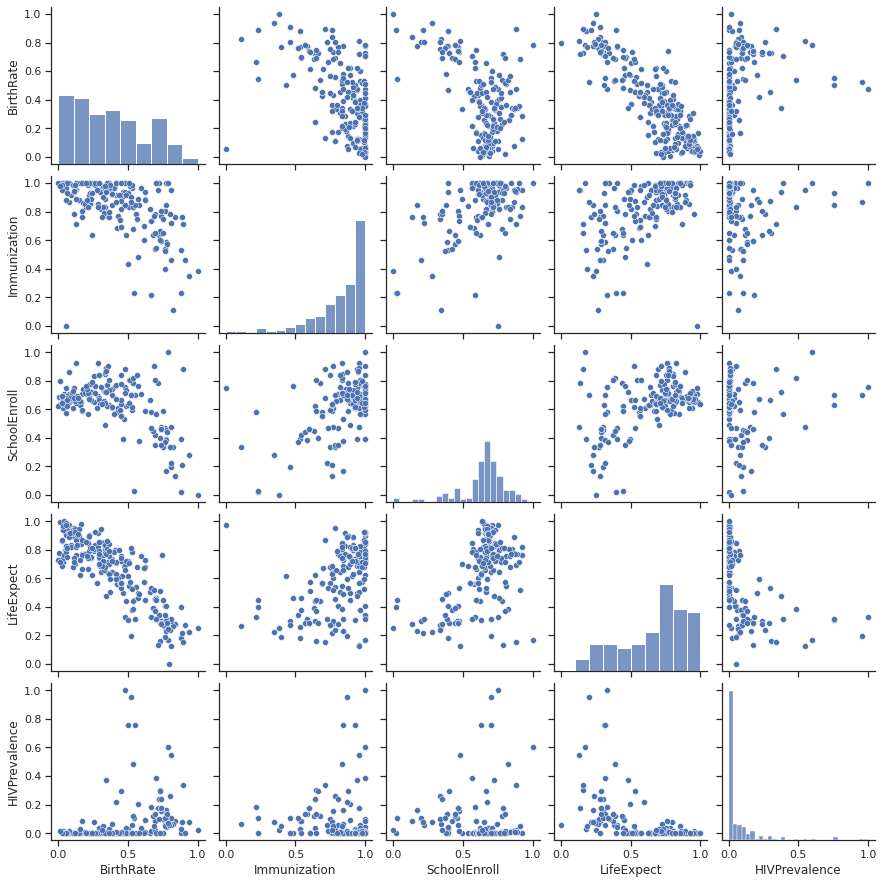

In [ ]:
scatter_list = ['Birth rate, crude (per 1,000 people)',
                'Immunization, BCG (% of one-year-old children)',
                'School enrollment, primary (% gross)',
                'Life expectancy at birth, total (years)',
                'Prevalence of HIV, total (% of population ages 15-49)']
sns.set_theme(style="ticks")

scatter_df = indicators_1998_num[scatter_list].rename(columns = {'Birth rate, crude (per 1,000 people)': 'BirthRate',
                                                             'Immunization, BCG (% of one-year-old children)': 'Immunization',
                                                             'School enrollment, primary (% gross)': 'SchoolEnroll',
                                                             'Life expectancy at birth, total (years)': 'LifeExpect',
                                                             'Prevalence of HIV, total (% of population ages 15-49)': 'HIVPrevalence'})
sns.pairplot(scatter_df)

After examing the correlation matrix, we get a final version of indicator list *select_indicator_3* and there are 34 indicators that we'll use in the modeling process.

In [ ]:
select_indicator_3 = [
'Country Code',
'Adolescent fertility rate (births per 1,000 women ages 15-19)',
'Birth rate, crude (per 1,000 people)',
'Death rate, crude (per 1,000 people)',
'Fertility rate, total (births per woman)',
'GNI per capita, Atlas method (current US$)',
'Immunization, BCG (% of one-year-old children)',
'Immunization, DPT (% of children ages 12-23 months)',
'Immunization, Pol3 (% of one-year-old children)',
'Immunization, measles (% of children ages 12-23 months)',
'Labor force, female (% of total labor force)',
'Labor force, total',
'Number of infant deaths',
'Number of neonatal deaths',
'Number of under-five deaths',
#'Population growth (annual %)',
'Population, female (% of total population)',
'Population, male (% of total population)',
'Population, total',
'Prevalence of HIV, female (% ages 15-24)',
'Prevalence of HIV, male (% ages 15-24)',
'Prevalence of HIV, total (% of population ages 15-49)',
'Prevalence of hypertension (% of adults ages 30-79)',
'Prevalence of hypertension, female (% of female adults ages 30-79)',
'Prevalence of hypertension, male (% of male adults ages 30-79)',
'Rural population (% of total population)',
#'Rural population growth (annual %)',
'School enrollment, primary (% gross)',
'School enrollment, primary, female (% gross)',
'School enrollment, primary, male (% gross)',
'Treatment for hypertension (% of adults ages 30-79 with hypertension)',
'Treatment for hypertension, female (% of female adults ages 30-79 with hypertension)',
'Treatment for hypertension, male (% of male adults ages 30-79 with hypertension)',
'Unemployment, female (% of female labor force)',
'Unemployment, male (% of male labor force)',
'Unemployment, total (% of total labor force)',
'Urban population (% of total population)',
#'Urban population growth (annual %)',
#'Population ages 65 and above (% of total population)'
]

In [ ]:
len(select_indicator_3)

35

### 1.1.4 Label Engineering

According to the classification standard of Population Aging established by the United Nations in 1956, an **aging** society is defined as a society with more than 7% of the population aged 65 or older; a population with more than 14% is an **aged** society, and a population with more than 20% is defined as a **super aging** society .


To get the label of aging level, we carry out label engineering with the indicator `Population ages 65 and above (% of total population)` from the original dataset.


In [ ]:
# dependent variable in 1998
dependent = Data[Data['Indicator Name'] == 'Population ages 65 and above (% of total population)'][['Country Code', '2018']].rename(columns = {'2018': 'Population ages 65 and above (% of total population)'})
dependent.head()

Country Code  Population ages 65 and above (% of total population)
300           AFE                                           3.126384   
741           AFW                                           2.782857   
1182          ARB                                           4.557908   
1623          CSS                                           8.796654   
2064          CEB                                          18.460477

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4bac03eb90>]],
      dtype=object)

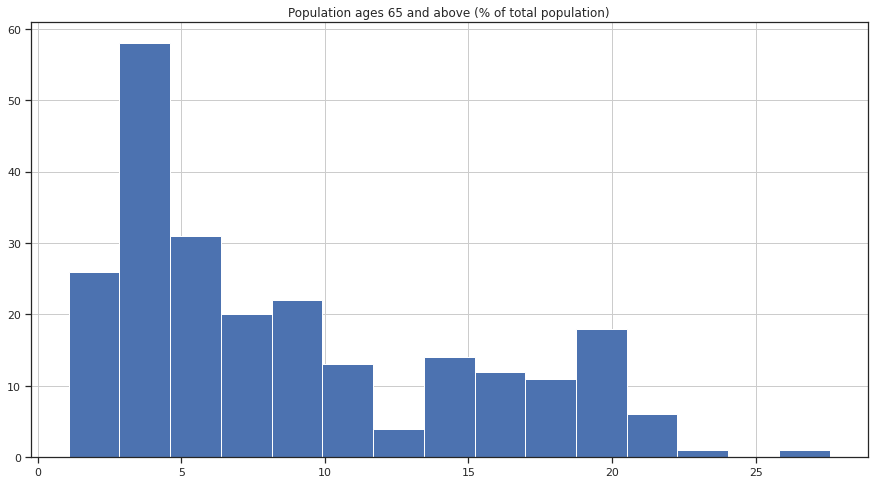

In [ ]:
dependent.hist(bins=15)

In [ ]:
# dependent_var['lable'] = dependent_var.apply(lambda x: 1 if x['Population ages 65 and above (% of total population)']>7 else 0)

dependent.loc[dependent['Population ages 65 and above (% of total population)'] >7, 'label'] = 'aging'
dependent.loc[dependent['Population ages 65 and above (% of total population)'] <=7, 'label'] = 'non-aging'
dependent.loc[dependent['Population ages 65 and above (% of total population)'] >14, 'label'] = 'aged'
dependent.loc[dependent['Population ages 65 and above (% of total population)'] >20, 'label'] = 'super-aging'

After droping countries who do not have aging label, **237 countries** are left.



In [ ]:
dependent = dependent.dropna()

In [ ]:
label = dependent[['label']]

In [ ]:
dependent_var = dependent[['Population ages 65 and above (% of total population)']]

### 1.1.5 Missing Value Compensation - KNN

After deciding our features, we need to examine the missing values in the dataframe.

In [ ]:
features = pd.merge(dependent[['Country Code']], indicators_1998[select_indicator_3],
                    how='left', on='Country Code').drop(columns='Country Code')

Most predictor columns have missing value before imputation.



In [ ]:
features.count()

Adolescent fertility rate (births per 1,000 women ages 15-19)                           237
Birth rate, crude (per 1,000 people)                                                    236
Death rate, crude (per 1,000 people)                                                    236
Fertility rate, total (births per woman)                                                235
GNI per capita, Atlas method (current US$)                                              214
Immunization, BCG (% of one-year-old children)                                          182
Immunization, DPT (% of children ages 12-23 months)                                     221
Immunization, Pol3 (% of one-year-old children)                                         221
Immunization, measles (% of children ages 12-23 months)                                 221
Labor force, female (% of total labor force)                                            230
Labor force, total                                                              

Imputating missing values using **k-NN** is a commonly-used method. Compared with dropping NAs and filling NAs with mean or median, KNN imputation can be more useful in making predictions about the missing values by finding the k’s closest neighbors to the observation with missing data and then imputing them based on the non-missing values in the neighborhood. 

In [ ]:
 #Increase the recursion limit of the OS
 sys.setrecursionlimit(100000)

# start the KNN training
features[features.columns]=fast_knn(features.values, k=30)

Now, all predictor missing values have been compensated.



In [ ]:
features.count()

Adolescent fertility rate (births per 1,000 women ages 15-19)                           237
Birth rate, crude (per 1,000 people)                                                    237
Death rate, crude (per 1,000 people)                                                    237
Fertility rate, total (births per woman)                                                237
GNI per capita, Atlas method (current US$)                                              237
Immunization, BCG (% of one-year-old children)                                          237
Immunization, DPT (% of children ages 12-23 months)                                     237
Immunization, Pol3 (% of one-year-old children)                                         237
Immunization, measles (% of children ages 12-23 months)                                 237
Labor force, female (% of total labor force)                                            237
Labor force, total                                                              

## 1.2 EDA

### 1.2.1 Feature Correlation

To visualize the correlation of our selected features and the independent variable, we make an interactive dashboard with hvplot-bokeh.

In [ ]:
columns = select_indicator_3.copy()
columns.append('Population ages 65 and above (% of total population)')
columns.remove('Country Code')

In [ ]:
data_eda = pd.merge(dependent, indicators_1998[select_indicator_3],
                    how='left', on='Country Code')
data = data_eda.copy().drop(columns={'label', 'Country Code'})

In [ ]:
def data_plot(x='Adolescent fertility rate (births per 1,000 women ages 15-19)', y='Population ages 65 and above (% of total population)', color='#058805'):
    return data_eda.hvplot.scatter(x, y, padding=0.1, by='label')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
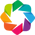

Row
    [0] Column
        [0] Markdown(str)
        [1] Column
            [0] Select(name='x', options=['Adolescent fertility rat...], value='Adolescent fertility rate...)
            [1] Select(name='y', options=['Adolescent fertility rat...], value='Population ages 6...)
    [1] Row
        [0] HoloViews(NdOverlay, name='interactive02331')

In [ ]:
hv.extension('bokeh')
# Create a widget to select the color of the scatter points
#color = pn.widgets.ColorPicker(name='Color', value='#4f4fdf')

# Auto-generate the layout
layout = pn.interact(data_plot, x=columns, y=columns)

# Create the dashboard with a Row and Column
interact_dashboard = pn.Row(
                        pn.Column('## Variable Explorer', layout[0]), 
                        layout[1]
                    )
interact_dashboard

**Feel free to interact with the *Variable Explorer*!** (If it isn't interactive, please run the code above.)

### 1.2.2 Time pattern of key features 

Life expectancy, birth rate, and aging population change with year in different sub-regions. We generate some charts exploring this kind of patterns.

In [ ]:
regions = ['East Asia & Pacific','South Asia','Sub-Saharan Africa', 'Latin America & Caribbean',
           'European Union', 'Middle East & North Africa', 'Arab World', 'North America']
region_df = Data[Data['Country Name'].isin(regions)]

In [ ]:
lifeExp = region_df[region_df['Indicator Name'] == 'Life expectancy at birth, total (years)']
lifeExp_lg = lifeExp.melt(id_vars=['Country Name'], value_vars=[str(year) for year in range(1989,2019)], 
                          var_name='Year', value_name='LifeExpectancy')

Text(0.5, 1.05, 'Life Expectancy Change with Time by Region')

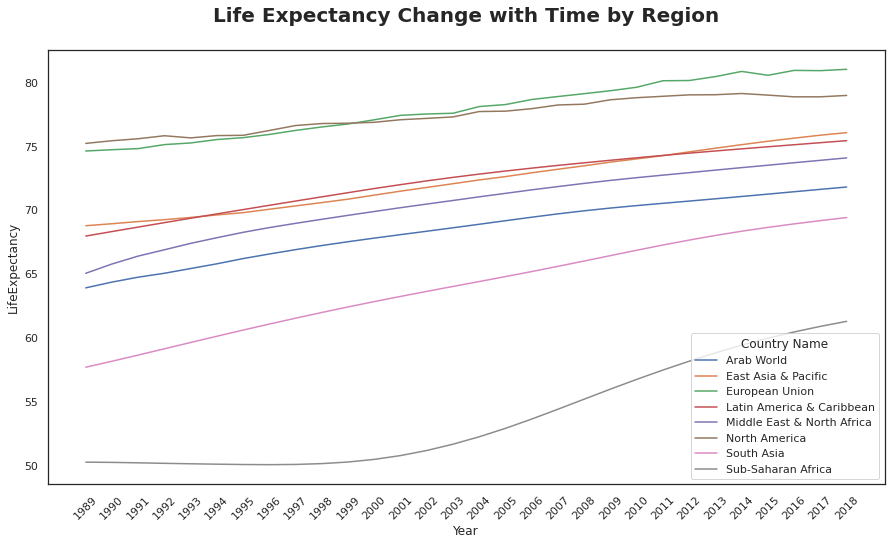

In [ ]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.set_theme(style="white")
chart_le = sns.lineplot(x="Year", y="LifeExpectancy",
             hue="Country Name", 
             data=lifeExp_lg)
plt.xticks(rotation = 45)
chart_le.set_title('Life Expectancy Change with Time by Region',
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)

In [ ]:
birth = region_df[region_df['Indicator Name'] == 'Birth rate, crude (per 1,000 people)']
birth_lg = birth.melt(id_vars=['Country Name'], value_vars= [str(year) for year in range(1989,2019)],
                      var_name='Year', value_name='BirthRate')

Text(0.5, 1.05, 'Birth Rate Change with Time by Region')

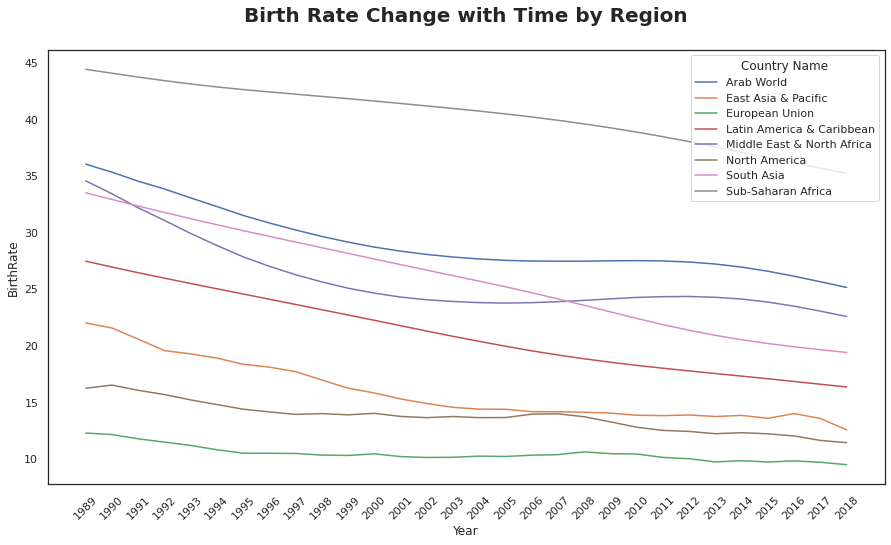

In [ ]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.set_theme(style="white")
chart_br = sns.lineplot(x="Year", y="BirthRate",
             hue="Country Name", 
             data=birth_lg)
plt.xticks(rotation = 45)
chart_br.set_title('Birth Rate Change with Time by Region',
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)


In [ ]:
aging = region_df[region_df['Indicator Name'] == 'Population ages 65 and above (% of total population)']
aging_lg = aging.melt(id_vars=['Country Name'], value_vars= [str(year) for year in range(1989,2019)],
                      var_name='Year', value_name='AgingRate').rename(columns = {'Country Name': 'Region'})

Text(0.5, 1.05, 'Aging Rate Change with Time by Region')

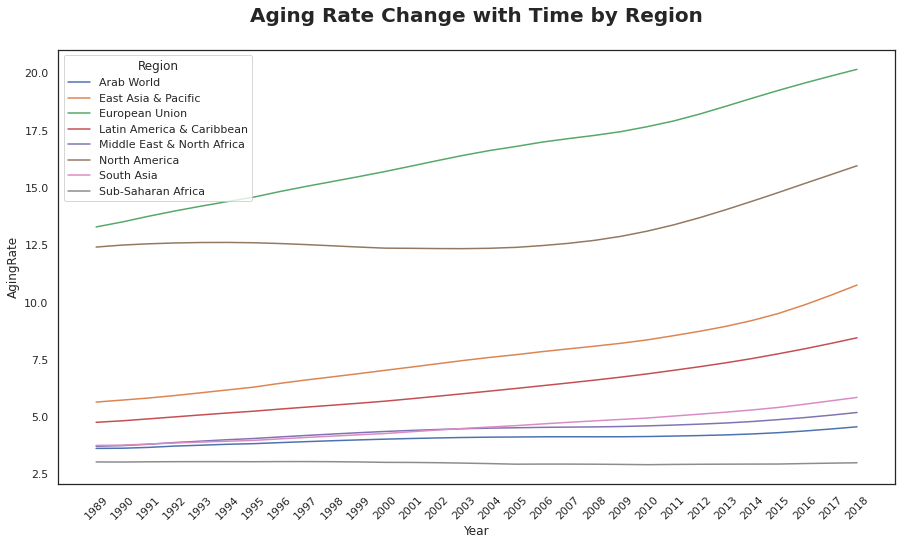

In [ ]:
sns.set(rc = {'figure.figsize':(15, 8)})
sns.set_theme(style="white")
chart_ag = sns.lineplot(x="Year", y="AgingRate",
             hue="Region", 
             data=aging_lg)
plt.xticks(rotation=45)
chart_ag.set_title('Aging Rate Change with Time by Region',
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)


In [ ]:
aging_country = Data[Data['Indicator Name'] == 'Population ages 65 and above (% of total population)'][['Country Code', '2018']]
aging_df = aging_country.merge(world_gpd[['iso_a3', 'geometry']], how = 'left', left_on='Country Code', right_on='iso_a3')
aging_gdf = gpd.GeoDataFrame(aging_df[aging_df.iso_a3.notna()], 
                             geometry=aging_df.geometry,
                             crs=4326).rename(columns = {'2018': '% Population ages 65 and above'})

Before we jump to the modeling part, we'd like to plot a map to show the current aging level across all countries. As is shown below, the map is interactive and you can move your mouse to see the PopUp with country code and aging level.

In [ ]:
# Plot the map
chart = (
    alt.Chart(aging_gdf)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["Country Code:N","% Population ages 65 and above:Q"],
        color=alt.Color("% Population ages 65 and above:Q", 
                        scale=alt.Scale(scheme='viridis'))
    ).properties(width = 600, 
                 height=400,
                 title='Aging Level accross Countries in 2018')
)

chart

alt.Chart(...)

## 1.3 Modeling

### 1.3.1 Train-test Split

Now we come to the modeling part. We train the models with multiple features from 1998 and aging labels from 2018. Then we'll predict the aging level of the year 2038 with features from 2018. 

The first thing to do is to split the training and test data. We split the dataset with a train-test ratio of 80% : 20%.

|         | Model Traing     | Model Prediction |
| ----------- | ----------- | ----------- |
| Features    | 1998        | 2018        |
| Label   | 2018       | 2038       |

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

To classify the aging level of given countries, we plan to test on three different machine learning models, *Random Forest*, *Support Vector Machine*, and *K-Nearest Neighbor*.

### 1.3.2 Random Forest

We build up an initial Random Forest model with mostly default hyperparameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier with n_estimators = 100
random.seed(1234)
clf = RandomForestClassifier(n_estimators = 300, max_depth = 100, random_state=1) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred_rf = clf.predict(x_test)
 
# metrics are used to find accuracy or error
#from sklearn import metrics 
#print()
 
# using metrics module for accuracy calculation
#print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_rf))

from sklearn import metrics
# print classification report
report_rf = metrics.classification_report(y_test, y_pred_rf, digits = 2)
print(report_rf)

              precision    recall  f1-score   support

        aged       0.67      0.73      0.70        11
       aging       0.75      0.86      0.80        14
   non-aging       1.00      0.90      0.95        20
 super-aging       0.50      0.33      0.40         3

    accuracy                           0.81        48
   macro avg       0.73      0.70      0.71        48
weighted avg       0.82      0.81      0.81        48



Given that classes are imbalanced here, we would mostly focus on accuracy and f1-score. The initial Random Forest classifier returns an overall accuracy of 0.81 which is fairly high. However, we still expect a better model performance.

To get the optimal hyperparameters for the Random Forest model, we apply grid search cross validation here on model tuning. We mainly tune on `bootstrap`, `max_depth`, and `n_estimators`.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [40, 60, 80, 100, 120],
    'n_estimators': [100, 200, 300, 500, 1000]
}
# Create a based model
rf = RandomForestClassifier(random_state=1)
# Instantiate the grid search model
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='accuracy')

grid_rf.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [40, 60, 80, 100, 120],
                         'n_estimators': [100, 200, 300, 500, 1000]},
             scoring='accuracy', verbose=2)

Here we print out the optimal hyperparameters, which are 'bootstrap': True, 'max_depth': 40, 'n_estimators': 100. We'll use these hyperparameters for the optimal RF model.

In [ ]:
grid_table = pd.DataFrame(grid_rf.cv_results_).sort_values(by='rank_test_score')
top_10 = grid_table[['params','mean_test_score','std_test_score','rank_test_score']].head(10)
top_10.reset_index().iloc[0]['params']

{'bootstrap': True, 'max_depth': 40, 'n_estimators': 100}

In [ ]:
random.seed(1234)
clf_optimal = RandomForestClassifier(n_estimators = 100, max_depth = 40, bootstrap = True, random_state=1) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf_optimal.fit(x_train, y_train)
 
# performing predictions on the test dataset
y_pred_rf_optimal = clf_optimal.predict(x_test)
 
# metrics are used to find accuracy or error
#from sklearn import metrics 
#print()
 
# using metrics module for accuracy calculation
#print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred_rf))

# print classification report
report_rf_optimal = metrics.classification_report(y_test, y_pred_rf_optimal, digits = 2)
print(report_rf_optimal)

              precision    recall  f1-score   support

        aged       0.69      0.82      0.75        11
       aging       0.75      0.86      0.80        14
   non-aging       1.00      0.90      0.95        20
 super-aging       1.00      0.33      0.50         3

    accuracy                           0.83        48
   macro avg       0.86      0.73      0.75        48
weighted avg       0.86      0.83      0.83        48



**Result of tuning hyperparameter**: We get a better model performance for our Random Forest classifier, with an accuracy of 0.83. Our model performs pretty good on the non-aging group, with a f1-score of 0.95. The performance on super-aging group is not that satisfying and one reason for that might be there are too few instances in this group.

Here we calculated the confusion matrix and plot it as a heat map.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat_rf = confusion_matrix(y_test, y_pred_rf_optimal,labels=clf_optimal.classes_)
print(conf_mat_rf)

[[ 9  2  0  0]
 [ 2 12  0  0]
 [ 0  2 18  0]
 [ 2  0  0  1]]


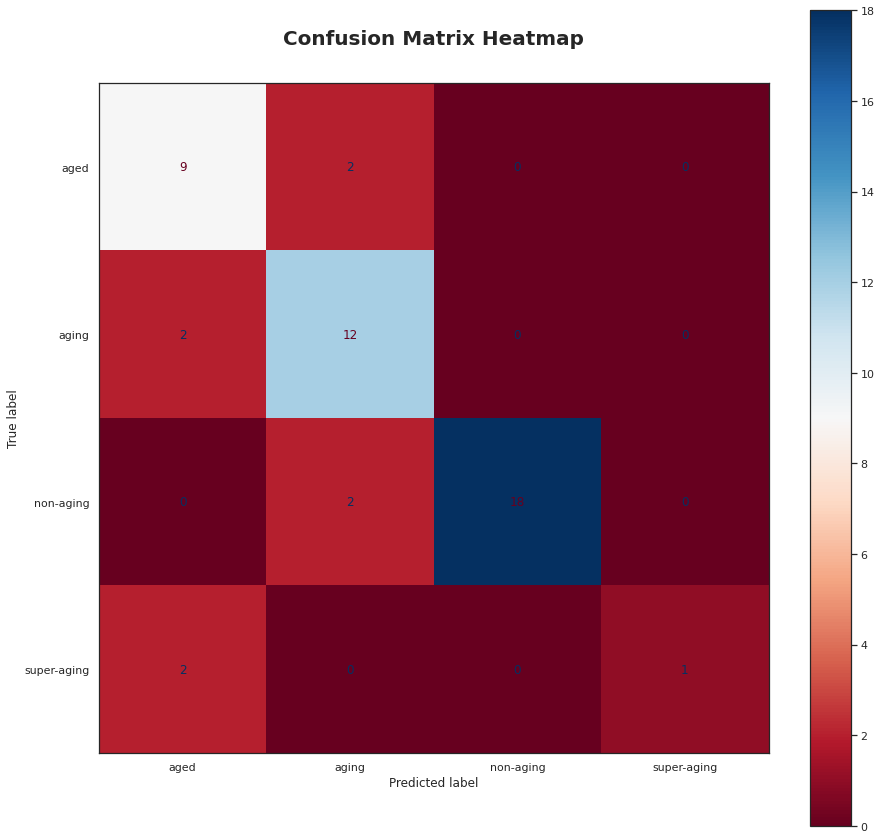

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.rcParams["axes.grid"] = False
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_rf,
                              display_labels=clf_optimal.classes_)
disp.plot(ax=ax, cmap = 'RdBu')
ax.set_title('Confusion Matrix Heatmap',
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)
plt.show()

We also examine the feature importances for the Random Forest classifier. As is shown below, the top-two important features are *Fertility Rate* and *Birth Rate* which are both strongly related to population and population structure from our common sense.

In [ ]:
feature_name = list(features.columns)
importances = clf_optimal.feature_importances_
forest_importances = pd.Series(importances, index=feature_name)
forest_importances = forest_importances.sort_values(ascending=False)

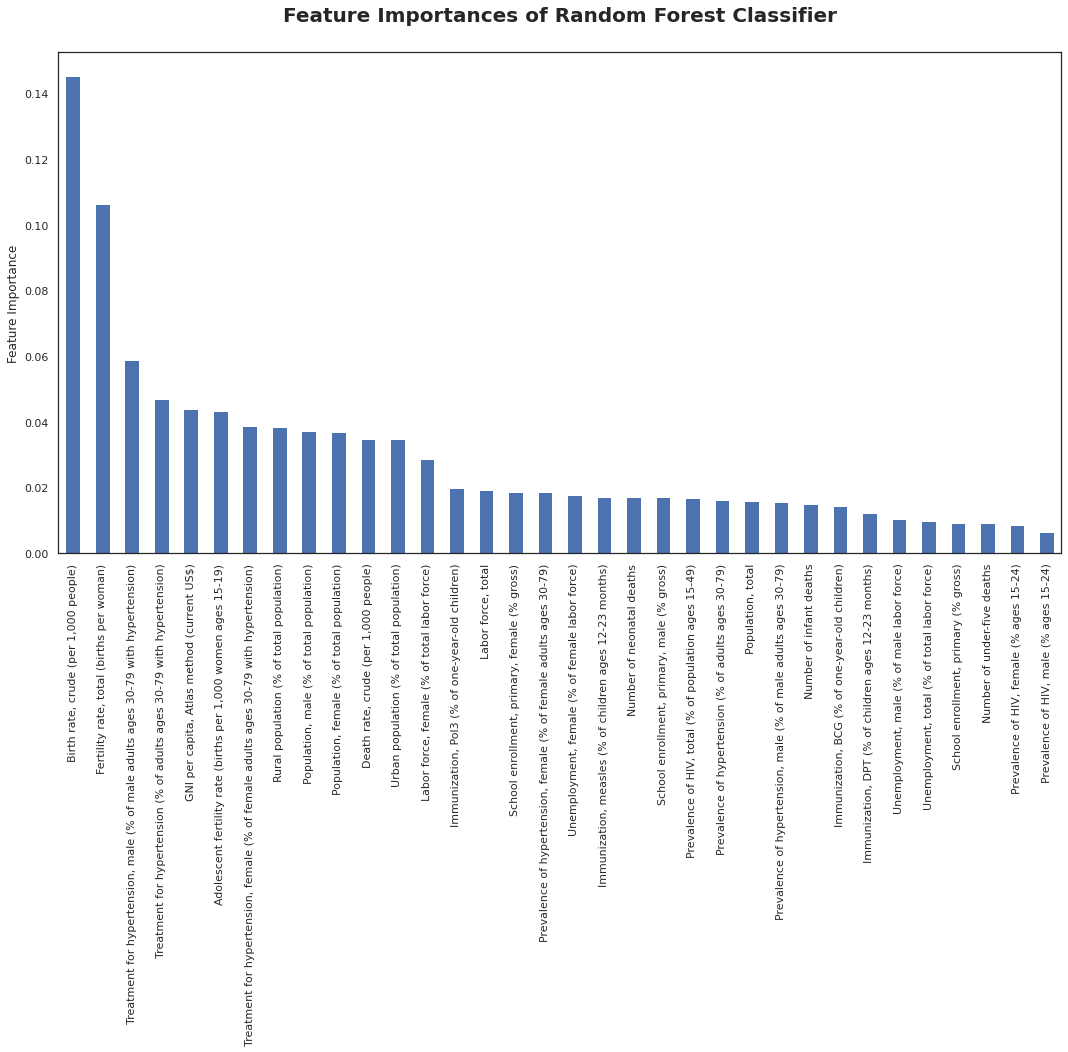

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances of Random Forest Classifier", 
             fontdict= { 'fontsize': 20, 'fontweight':'bold'},
             y =1.05)
ax.set_ylabel("Feature Importance")
fig.tight_layout()

### 1.3.3 Support Vector Machine

Initialize a SVM model with the basic linear kernel and evaluate performance on test sample. 

In [ ]:
# to accelerate the computing process, we need to scale data first
from sklearn import preprocessing
x_train_scale = preprocessing.scale(x_train)
x_test_scale = preprocessing.scale(x_test)

from sklearn.svm import SVC 
# creating a svm classifier with linear kernel
svm = SVC(kernel = 'linear')

# training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
svm.fit(x_train_scale, y_train)

# performing predictions on the test dataset
y_pred_svm = svm.predict(x_test_scale)

# print classification report
report_svm = metrics.classification_report(y_test, y_pred_svm, digits = 2)
print(report_svm)

              precision    recall  f1-score   support

        aged       0.50      0.55      0.52        11
       aging       0.55      0.43      0.48        14
   non-aging       0.79      0.95      0.86        20
 super-aging       0.00      0.00      0.00         3

    accuracy                           0.65        48
   macro avg       0.46      0.48      0.47        48
weighted avg       0.60      0.65      0.62        48



Now, Tune the hyperparameter by changing into RBF kernel, and evaluate performance on test sample. 

In [ ]:
# creating a svm classifier with linear kernel
svm = SVC(kernel = 'rbf')

# training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
svm.fit(x_train_scale, y_train)

# performing predictions on the test dataset
y_pred_svm = svm.predict(x_test_scale)

# print classification report
report_svm = metrics.classification_report(y_test, y_pred_svm, digits = 2)
print(report_svm)

              precision    recall  f1-score   support

        aged       0.69      0.82      0.75        11
       aging       0.67      0.57      0.62        14
   non-aging       0.78      0.90      0.84        20
 super-aging       0.00      0.00      0.00         3

    accuracy                           0.73        48
   macro avg       0.54      0.57      0.55        48
weighted avg       0.68      0.73      0.70        48



**Result of tuning hyperparameter**: SVM model with RBF kernel is better, the accuracy is 0.73.


### 1.3.4 KNN

Initialize a KNN classification mode with `n_neighbors=3` and evaluate performance on test sample. 


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# creating a knn classifier with default k=3
knn = KNeighborsClassifier(n_neighbors=3)

# training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
knn.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred_knn = knn.predict(x_test)

# print classification report
report_knn = metrics.classification_report(y_test, y_pred_knn, digits = 2)
print(report_knn)

              precision    recall  f1-score   support

        aged       0.11      0.09      0.10        11
       aging       0.38      0.21      0.27        14
   non-aging       0.47      0.70      0.56        20
 super-aging       0.00      0.00      0.00         3

    accuracy                           0.38        48
   macro avg       0.24      0.25      0.23        48
weighted avg       0.33      0.38      0.34        48



Now, tune the hyperparameter K (n_neighbors) with `GridSearchCV`.


In [ ]:
# defining a list for K
k_list = list(range(1,31))

# transform list to dict
k_values = dict(n_neighbors = k_list)

from sklearn.model_selection import GridSearchCV
# instantiating the GridSearch
grid = GridSearchCV(knn, k_values, cv=10, scoring='accuracy')

# training the GridSearch
grid.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [ ]:
# checking scores of classifiers with different K
grid_table = pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score')
grid_table[['params','mean_test_score','std_test_score','rank_test_score']].head(10)

params  mean_test_score  std_test_score  rank_test_score
13  {'n_neighbors': 14}         0.545029        0.057762                1
17  {'n_neighbors': 18}         0.529240        0.058318                2
27  {'n_neighbors': 28}         0.523977        0.018895                3
21  {'n_neighbors': 22}         0.523977        0.055921                3
19  {'n_neighbors': 20}         0.523977        0.055921                3
18  {'n_neighbors': 19}         0.523977        0.069204                3
28  {'n_neighbors': 29}         0.523977        0.018895                3
14  {'n_neighbors': 15}         0.518713        0.066782                8
26  {'n_neighbors': 27}         0.518713        0.024119                8
20  {'n_neighbors': 21}         0.518713        0.066782                8

Fit the knn model with the best K value, 14, and evaluate its performance on test sample. 


In [ ]:
# creating a knn classifier with k=14
knn2 = KNeighborsClassifier(n_neighbors=14)

# training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
knn2.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred_knn2 = knn2.predict(x_test)

# print classification report
report_knn2 = metrics.classification_report(y_test, y_pred_knn2, digits = 2)
print(report_knn2)

              precision    recall  f1-score   support

        aged       0.00      0.00      0.00        11
       aging       1.00      0.07      0.13        14
   non-aging       0.43      0.95      0.59        20
 super-aging       0.00      0.00      0.00         3

    accuracy                           0.42        48
   macro avg       0.36      0.26      0.18        48
weighted avg       0.47      0.42      0.29        48



In [ ]:
# creating a knn classifier with k=2
knn3 = KNeighborsClassifier(n_neighbors=2)

# training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
knn3.fit(x_train, y_train)

# performing predictions on the test dataset
y_pred_knn3 = knn3.predict(x_test)

# print classification report
report_knn3 = metrics.classification_report(y_test, y_pred_knn3, digits = 2)
print(report_knn3)

              precision    recall  f1-score   support

        aged       0.30      0.55      0.39        11
       aging       0.26      0.36      0.30        14
   non-aging       0.67      0.30      0.41        20
 super-aging       0.00      0.00      0.00         3

    accuracy                           0.35        48
   macro avg       0.31      0.30      0.28        48
weighted avg       0.42      0.35      0.35        48



**Result of tuning hyperparameter**: KNN model with 14 neighbors performs best, the accuracy is 0.44.




## 1.4 Predictions for Aging Level 20 Years Later

Now we make predictions on the aging level of the year 2038 based on the **optimal Random Forest Classifier** we trained above. As a reminder, we classify the country's aging level into four labels, 

| Aging Population (%)   | Label |
| ----------- | ----------- | 
| Less than 7   | non-aging      | 
| More than 7 and less than 14   | aging     | 
| More than 14 and less than 20   | aged     | 
| More than 20   | super-aging     | 


### 1.4.1 Prediction Results

In [ ]:
country_pred = dependent[['Country Code']].drop_duplicates()

In [ ]:
select_indicator_3.remove('Country Code')

In [ ]:
for i in select_indicator_3:
  indicator_i = Data[Data['Indicator Name'] == i][['Country Code', '2018']].rename(columns = {'2018': i})
  country_pred = pd.merge(country_pred, indicator_i, on = 'Country Code', how='left')
country_pred

Country Code  \
0            AFE   
1            AFW   
2            ARB   
3            CSS   
4            CEB   
..           ...   
232          VIR   
233          PSE   
234          YEM   
235          ZMB   
236          ZWE   

     Adolescent fertility rate (births per 1,000 women ages 15-19)  \
0                                            94.695223               
1                                           111.056406               
2                                            46.002723               
3                                            50.215491               
4                                            19.436567               
..                                                 ...               
232                                          27.648200               
233                                          51.882800               
234                                          59.162400               
235                                         118.304800               
236                                          83.248600               

     Birth rate, crude (per 1,000 people)  \
0                               33.913034   
1                               37.148465   
2                               25.147101   
3                               15.886778   
4                               10.100581   
..                                    ...   
232                             12.600000   
233                             29.282000   
234                             30.453000   
235                             36.192000   
236                             30.676000   

     Death rate, crude (per 1,000 people)  \
0                                7.521453   
1                               10.166492   
2                                5.380288   
3                                7.589480   
4                               12.117400   
..                                    ...   
232                              7.900000   
233                              3.461000   
234                              5.983000   
235                              6.456000   
236                              7.883000   

     Fertility rate, total (births per woman)  \
0                                    4.420264   
1                                    5.113003   
2                                    3.231001   
3                                    1.995134   
4                                    1.574609   
..                                        ...   
232                                  2.060000   
233                                  3.643000   
234                                  3.792000   
235                                  4.633000   
236                                  3.615000   

     GNI per capita, Atlas method (current US$)  \
0                                   1494.710171   
1                                   1611.865620   
2                                   6171.011768   
3                                   9617.879122   
4                                  14658.671664   
..                                          ...   
232                                         NaN   
233                                 4190.000000   
234                                  910.000000   
235                                 1440.000000   
236                                 1350.000000   

     Immunization, BCG (% of one-year-old children)  \
0                                         80.029451   
1                                         77.249120   
2                                         88.389688   
3                                               NaN   
4                                         88.369534   
..                                              ...   
232                                             NaN   
233                                             NaN   
234                                       64.000000   
235                                       91.000000   
236                              

In [ ]:
country_pred = country_pred.fillna(0)

In [ ]:
feature_pred = country_pred[select_indicator_3]

In [ ]:
label_pred = clf.predict(feature_pred)

In [ ]:
country_pred['label_pred'] = label_pred
result = country_pred[['Country Code', 'label_pred']]

### 1.4.2 Prediction Visualization

#### 1.4.2.1 Map

In [ ]:
world_gpd = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_gpd

pop_est      continent                      name iso_a3  gdp_md_est  \
0       920938        Oceania                      Fiji    FJI      8374.0   
1     53950935         Africa                  Tanzania    TZA    150600.0   
2       603253         Africa                 W. Sahara    ESH       906.5   
3     35623680  North America                    Canada    CAN   1674000.0   
4    326625791  North America  United States of America    USA  18560000.0   
..         ...            ...                       ...    ...         ...   
172    7111024         Europe                    Serbia    SRB    101800.0   
173     642550         Europe                Montenegro    MNE     10610.0   
174    1895250         Europe                    Kosovo    -99     18490.0   
175    1218208  North America       Trinidad and Tobago    TTO     43570.0   
176   13026129         Africa                  S. Sudan    SSD     20880.0   

                                              geometry  
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2    POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3    MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4    MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
..                                                 ...  
172  POLYGON ((18.82982 45.90887, 18.82984 45.90888...  
173  POLYGON ((20.07070 42.58863, 19.80161 42.50009...  
174  POLYGON ((20.59025 41.85541, 20.52295 42.21787...  
175  POLYGON ((-61.68000 10.76000, -61.10500 10.890...  
176  POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...  

[177 rows x 6 columns]

In [ ]:
result_gpd = result.merge(world_gpd[['iso_a3', 'geometry']], how = 'left', left_on='Country Code', right_on='iso_a3')
result_gpd = gpd.GeoDataFrame(result_gpd, geometry=result_gpd.geometry)
# len(result_gpd[result_gpd['geometry'].isna()])

In [ ]:
result_gpd

Country Code label_pred iso_a3  \
0            AFE  non-aging    NaN   
1            AFW  non-aging    NaN   
2            ARB  non-aging    NaN   
3            CSS      aging    NaN   
4            CEB       aged    NaN   
..           ...        ...    ...   
232          VIR      aging    NaN   
233          PSE  non-aging    PSE   
234          YEM  non-aging    YEM   
235          ZMB  non-aging    ZMB   
236          ZWE  non-aging    ZWE   

                                              geometry  
0                                                 None  
1                                                 None  
2                                                 None  
3                                                 None  
4                                                 None  
..                                                 ...  
232                                               None  
233  POLYGON ((35.39756 31.48909, 34.92741 31.35344...  
234  POLYGON ((52.00001 19.00000, 52.78218 17.34974...  
235  POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...  
236  POLYGON ((31.19141 -22.25151, 30.65987 -22.151...  

[237 rows x 4 columns]

Another interactive map is plotted here to help visualize the aging level we predict form our model.

In [ ]:
result_chart = (
    alt.Chart(result_gpd)
    .mark_geoshape(stroke="white")
    .encode(
        tooltip=["Country Code:N","label_pred:N"],
        color=alt.Color("label_pred:N", 
                        scale=alt.Scale(scheme='viridis'),
                        legend=alt.Legend(title="Predicted Aging Label"))
    ).properties(width = 600, 
                 height=600,
                 title='Predicted Aging Label accross Countries in 2038')
)

result_chart

alt.Chart(...)

#### 1.4.2.1 Histogram

In [ ]:
result

Country Code label_pred
0            AFE  non-aging
1            AFW  non-aging
2            ARB  non-aging
3            CSS      aging
4            CEB       aged
..           ...        ...
232          VIR      aging
233          PSE  non-aging
234          YEM  non-aging
235          ZMB  non-aging
236          ZWE  non-aging

[237 rows x 2 columns]

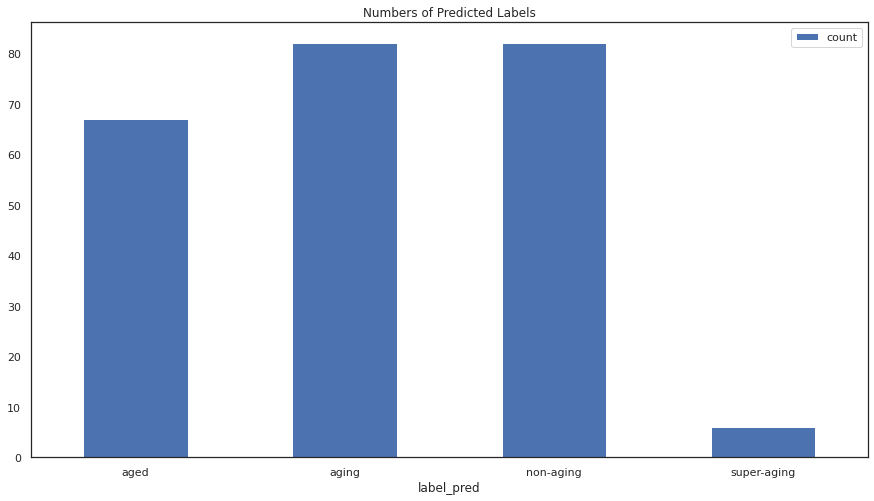

In [ ]:
result.groupby('label_pred').count().reset_index().rename(columns = {'Country Code': 'count'}).plot.bar(x='label_pred', y='count', rot=0)
title = plt.title('Numbers of Predicted Labels')

We also make a histogram of the predicted labels. We can see that there are few instances in the super-aging group and that’s one of the reasons why our model performs not that well with that group.


However, most of the countries worldwide still enter an aging stage by 2038. It’s a tough task for governments to deal with the problems brought by population aging, especially for those countries that will walk into aged and even super-aging stage.


# 2.Time-Series Prediction for Birth Rate in 20 Years

From the results of the aging classification we can learn that the **birth rate** is the **most important factor** affecting the degree of aging. Therefore, in this part, we now take the birth rate in the **United States** as an example to explore whether it has a cycle and use a time series model to forecast it for the next 20 years.



We firstly loaded the birth rates data of all countries from 1960 to 2019. 

In [ ]:
url2 = 'https://raw.githubusercontent.com/keeea/Worldwide-Population-Aging-and-Birth-Rate/main/data/only_birth_rate_data.csv'
BirthRate2 = pd.read_csv(url2)

## 2.1 Data Cleaning and Wrangling

Firstly, the birth rates of America were filtered out. The raw data is wide format, and we need to convert it to long format for data analysis and prediction. Converting 'year' column from str to datetime is also indispensible for time series analysis, and it is also the index of the dataframe.

In [ ]:
America_birthrate = BirthRate2.loc[(BirthRate2['Series Code'] == 'SP.DYN.CBRT.IN') & (BirthRate2['Country Code'] == 'USA')]
America_birthrate = America_birthrate.iloc[0,4:64].astype('float')

In [ ]:
America_birthrate_df = pd.DataFrame(America_birthrate)
America_birthrate_df = America_birthrate_df.reset_index().rename(columns = {253:'birth rate','index':'year'})
America_birthrate_df.year = America_birthrate_df.year.str[:5]
America_birthrate_df['year'] = pd.to_datetime(America_birthrate_df['year'])
America_birthrate_df = America_birthrate_df.set_index('year')

In [ ]:
America_birthrate_df.tail()

birth rate
year                  
2015-01-01        12.4
2016-01-01        12.2
2017-01-01        11.8
2018-01-01        11.6
2019-01-01        11.4

## 2.2 Assumption Test and Data Preprocessing

### 2.2.1 White Noise Testing

Before we formally start time series analysis, we need to test whether this time series is **white noise**. If the time seires is white noise, it is a sequence of random numbers, indicating there is no rule in the time series and we can't predict it.   
The fastest way of detecting whether the time series is white noise is **ljungbox test**. If p-value is less than 0.05, then the null hypothesis that the time series is white noise can be rejected.


In [ ]:
#autocorrelation_plot(America_birthrate_df)

In [ ]:
# ljungbox test
lbtest = sm.stats.acorr_ljungbox(America_birthrate_df, lags=[10])
lbtest

lb_stat     lb_pvalue
10  177.085023  9.434339e-33

**After ljungbox test, we found p value is much smaller than 0.05, so birth rates series is not white noises and we can continue to analysis it.**

### 2.2.3 Stationarity Test

#### 2.2.3.1 Time Series Visualization

Now, let's firstly have a basic understanding of the time series of birth rates. The overall trend is **declining**. The rate of decline in the birth rate was rapid from 1960 to 1970, and then slowed down. 1960 was the year with the highest birth rate in 60 years, and 2019 was the year with the lowest birth rate. Around 1970 and 1990, the birth rate had a brief rebound, but soon dropped again.

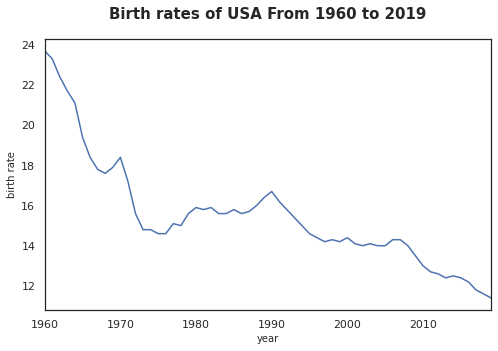

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
America_birthrate_df['birth rate'].plot(ax=ax)
plt.ylabel('birth rate',size = 10)
plt.xlabel('year',size = 10)
ax.set_title('Birth rates of USA From 1960 to 2019',
             fontdict= { 'fontsize': 15, 'fontweight':'bold'},
             y =1.05)
plt.show()

Below is a figure showing the frequency of birth rates in USA from 1960 to 1990. It is apparent that most of birth rates are oncentrated between 14 and 16. And the frequency between 19-24 is relatively low.  

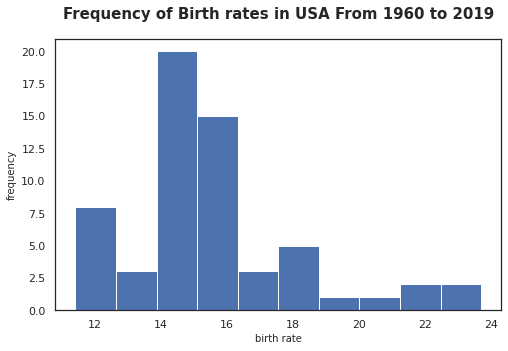

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

plt.hist(America_birthrate_df['birth rate'], density=False)

plt.xlabel('birth rate',size = 10)
plt.ylabel('frequency',size = 10)
ax.set_title('Frequency of Birth rates in USA From 1960 to 2019',
             fontdict= { 'fontsize': 15, 'fontweight':'bold'},
             y =1.05)
plt.show()

#### 2.2.3.2 Rolling Statistics


Based on above two figures, we inferred that there was a significant descending trend in the time series. There might be a seasonal pattern because of two slightly similar waves. Out of prudence, let's test the **stationarity** of the time series of birth rates. Before we can build a model, we must ensure that the time series is stationary. 


Firstly, we plot the rolling mean and **rolling** standard deviation. The time series is stationary if they remain constant with time. And the outcome was shown as below.

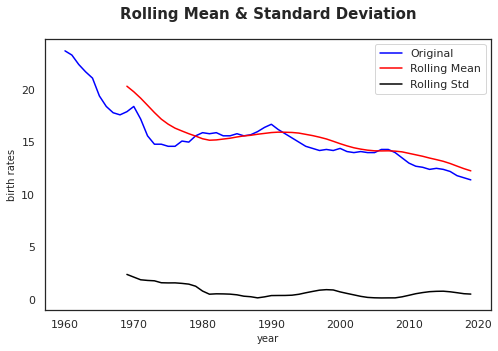

In [ ]:
rolmean = pd.Series.rolling(America_birthrate_df['birth rate'], center=False, window=10).mean()
rolstd = pd.Series.rolling(America_birthrate_df['birth rate'], center=False, window=10).std()

fig, ax = plt.subplots(figsize=(8, 5))
orig = plt.plot(America_birthrate_df['birth rate'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.xlabel('year',size = 10)
plt.ylabel('birth rates',size = 10)
ax.set_title('Rolling Mean & Standard Deviation',
             fontdict= { 'fontsize': 15, 'fontweight':'bold'},
             y =1.05)
plt.show(block=False)

**The line of rolling mean was not straight and parallel to x-axis, which indicated the time series was not stationary and there was an overall decreasing trend.**

#### 2.2.3.3 Augmented Dickey-Fuller Test

We can also test whether the time series is **stationary** or not by **Augmented Dickey-Fuller Test**. The time series is considered stationary if the p-value is low.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def get_stationarity(timeseries):
    
  # rolling statistics
  rolling_mean = timeseries.rolling(window=10).mean()
  rolling_std = timeseries.rolling(window=10).std()
  
  # rolling statistics plot
  fig, ax = plt.subplots(figsize=(8, 5))
  original = plt.plot(timeseries, color='blue', label='Original')
  mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
  std = plt.plot(rolling_std, color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.xlabel('year',size = 8)
  plt.ylabel('birth rates',size = 8)
  ax.set_title('Rolling Mean & Standard Deviation',
             fontdict= { 'fontsize': 15, 'fontweight':'bold'},
             y =1.05)
  plt.show(block=False)
  
  # Dickey–Fuller test:
  result = adfuller(timeseries['birth rate'])
  print('ADF Statistic: {}'.format(result[0]))
  print('p-value: {}'.format(result[1]))
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t{}: {}'.format(key, value))
  print('Lags: {}'.format(result[2]))

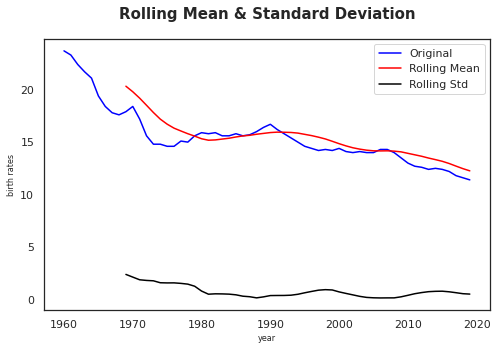

ADF Statistic: -2.572218353401204
p-value: 0.09887617919849889
Critical Values:
	1%: -3.5506699942762414
	5%: -2.913766394626147
	10%: -2.5946240473991997
Lags: 2


In [ ]:
get_stationarity(America_birthrate_df)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, **the time series is in fact non-stationary**.

### 2.2.4 Trends and Seasonal Patterns

#### 2.2.4.1 Seasonal Decompose

Firstly, We break down our birth rate time series into its trend, seasonality, and residual components. We also plot them respectively. The outcomes show that there is a downward trend, but there is **no seasonal patterns**.

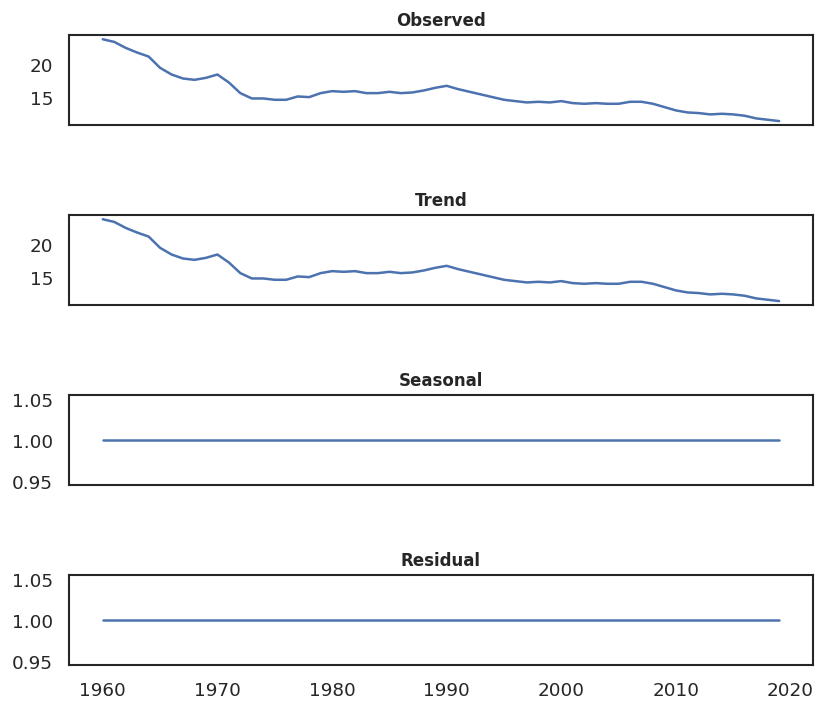

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result_mult = seasonal_decompose(America_birthrate_df, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

#decompose_result_mult.plot();

# plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
# fig, axes = plt.subplots(4, 1, sharex=True)

plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(4, 1, sharex=True)


axes[0].plot(America_birthrate_df)
axes[1].plot(trend)
axes[2].plot(seasonal)
axes[3].plot(residual)

axes[0].set_title('Observed', size=10, fontdict = {'fontweight':'bold'})
axes[1].set_title('Trend', size=10, fontdict = {'fontweight':'bold'})
axes[2].set_title('Seasonal', size=10, fontdict = {'fontweight':'bold'})
axes[3].set_title('Residual', size=10, fontdict = {'fontweight':'bold'})


plt.subplots_adjust(top=1, 
                    wspace=0.4, 
                    hspace=1)

plt.show()

Based on figures, it could be concluded that **there was a descending trend and no seasonal patterns in the time series.**

#### 2.2.4.2 Fast Fourier Transform (FFT)

Another way to test the cycle of time series is Fast Fourier Transform (FFT).

In [ ]:
US_birthrate = BirthRate2.loc[(BirthRate2['Series Code'] == 'SP.DYN.CBRT.IN') & (BirthRate2['Country Code'] == 'USA')]

In [ ]:
US_series = US_birthrate.iloc[0,4:64].astype('float')

In [ ]:
from scipy.fftpack import fft, fftfreq

fft_series = fft(US_series.values)


In [ ]:
power = np.abs(fft_series)
sample_freq = fftfreq(fft_series.size)

pos_mask = np.where(sample_freq > 0)
freqs = sample_freq[pos_mask]
powers = power[pos_mask]

top_k_seasons = 3
# top K=3 index
top_k_idxs = np.argpartition(powers, -top_k_seasons)[-top_k_seasons:]
top_k_power = powers[top_k_idxs]
fft_periods = (1 / freqs[top_k_idxs]).astype(int)


print(f"top_k_power: {top_k_power}")
print(f"fft_periods: {fft_periods}")

top_k_power: [48.82649002 53.90685392 56.53789496]
fft_periods: [20 60 30]


In [ ]:
from statsmodels.tsa.stattools import acf
 
# Expected time period
for lag in fft_periods:
    #lag = fft_periods[np.abs(fft_periods - time_lag).argmin()]
    acf_score = acf(US_series, nlags=lag)[-1]
    print(f"lag: {lag} fft acf: {acf_score}")
 
 
# expected_lags = np.array([2,5,10,15]).astype(int)

# for lag in expected_lags:
#     acf_score = acf(US_series, nlags=lag, fft=False)[-1]
#     print(f"lag: {lag} expected acf: {acf_score}")


lag: 20 fft acf: 0.07927919288113289
lag: 60 fft acf: -0.07698442176963949
lag: 30 fft acf: -0.02940155665597528


Given that the acf score is so low here, **there's no strong cycle in birth rate time series.**

### 2.2.5 Rendering the Time Series Stationary

We took the **log** of the time series, which is a simple way of lowering the rate at which rolling mean decreases.

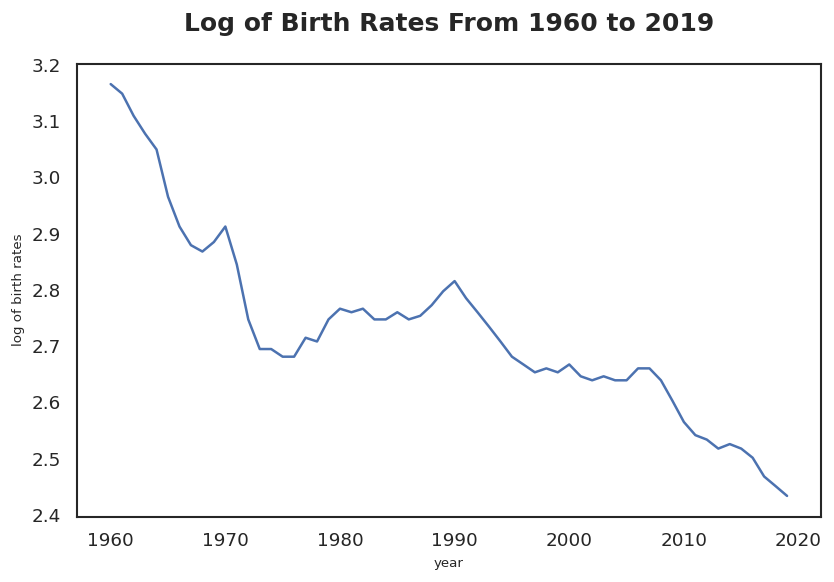

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
AB_log = np.log(America_birthrate_df)
log = plt.plot(AB_log)
plt.xlabel('year',size = 8)
plt.ylabel('log of birth rates',size = 8)
ax.set_title('Log of Birth Rates From 1960 to 2019',
            fontdict= { 'fontsize': 15, 'fontweight':'bold'},
            y =1.05)
plt.show(block=False)

There are many ways of transformations that we can apply to a time series to render it stationary. Here we mainly choose two methods, namely **substracting rolling mean** and **exponential decay**, and compare their performance.

#### 2.2.5.1 Substracting Rolling Mean

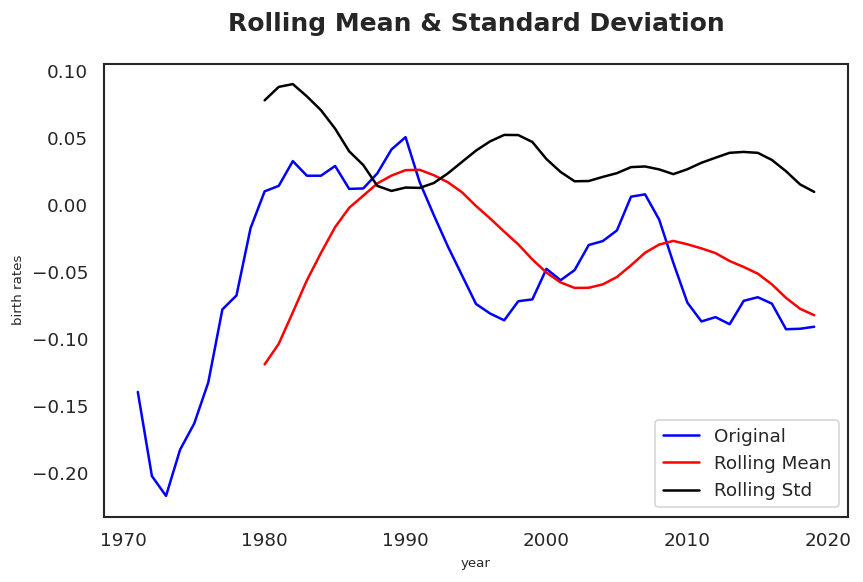

ADF Statistic: -3.6461432583079603
p-value: 0.0049377306189728794
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064
Lags: 1


In [ ]:
rolling_mean = AB_log.rolling(window=12).mean()
AB_log_minus_mean = AB_log - rolling_mean
AB_log_minus_mean.dropna(inplace=True)
get_stationarity(AB_log_minus_mean)

Based on the outcome above, after subtracting the mean, the rolling mean and standard deviation were flatter than before. The p-value is only 0.0049 and much smaller than 0.01. Therefore, **the time series is stationary now**.


#### 2.2.5.2 Exponential Decay

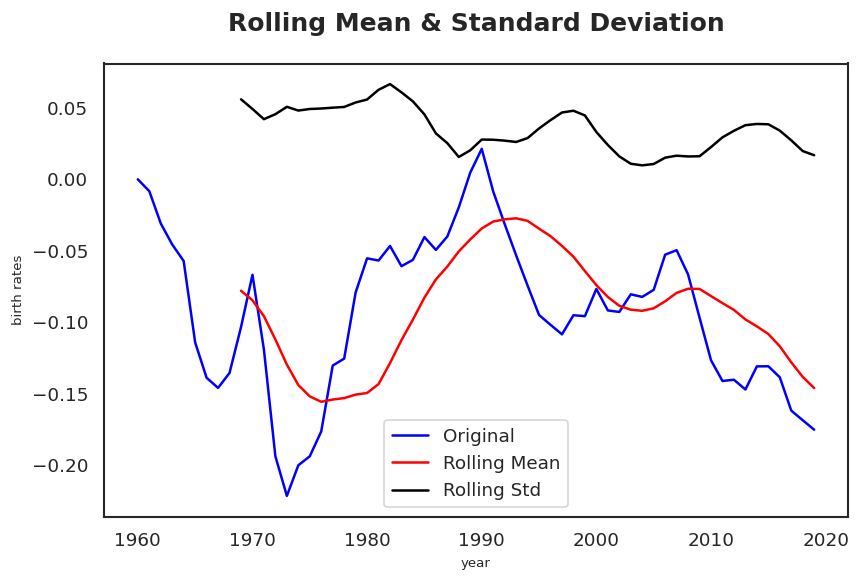

ADF Statistic: -2.8633057697398874
p-value: 0.04978445813311418
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944
Lags: 1


In [ ]:
rolling_mean_exp_decay = AB_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
AB_log_exp_decay = AB_log - rolling_mean_exp_decay
AB_log_exp_decay.dropna(inplace=True)
get_stationarity(AB_log_exp_decay)

The p-value after exponential decay is 0.0497, which was close to 0.05. It is more stationary than the original, but it performed worse than subtracting the rolling mean. So we will use the data after substracting the rolling mean to build model in the next part.

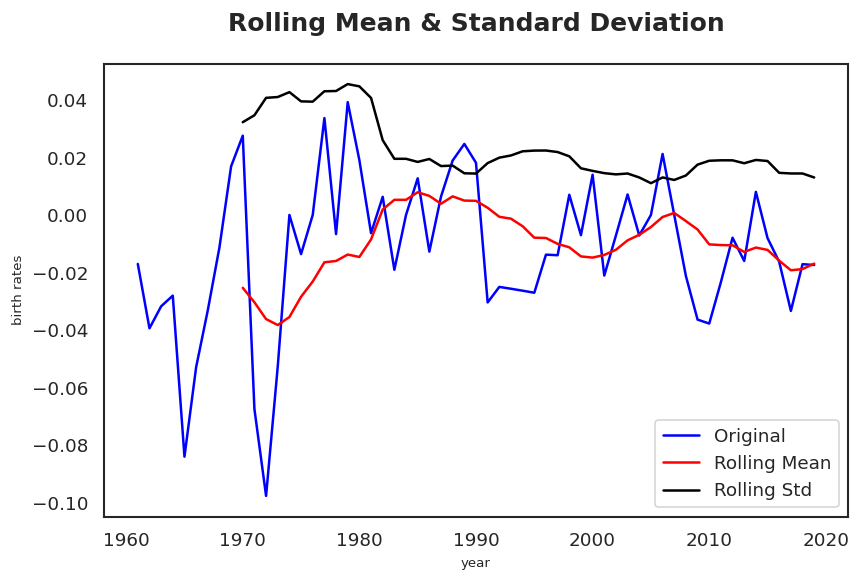

ADF Statistic: -4.227949620555618
p-value: 0.0005906830899234942
Critical Values:
	1%: -3.548493559596539
	5%: -2.912836594776334
	10%: -2.594129155766944
Lags: 0


In [ ]:
AB_log_shift = AB_log - AB_log.shift()
AB_log_shift.dropna(inplace=True)
get_stationarity(AB_log_shift)

## 2.3 Modeling - ARIMA 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [ ]:
AB_log = AB_log.dropna()

When building an Arima Model, there are three important hyperparameters:


1.   p: number of autoregressive terms (AR order)
2.   d: number of nonseasonal differences (differencing order)
3.   q: number of moving-average terms (MA order)  

We were going to choose the best parameters.



### 2.3.1 The Order of Differencing

Since our time series after log transformation was still not stationary, so we needed differencing. Below were acf diagrams of the original time series, after the first-order difference, and after the second-order difference.

In [ ]:
AB_log_1 = AB_log.reset_index(drop = True)

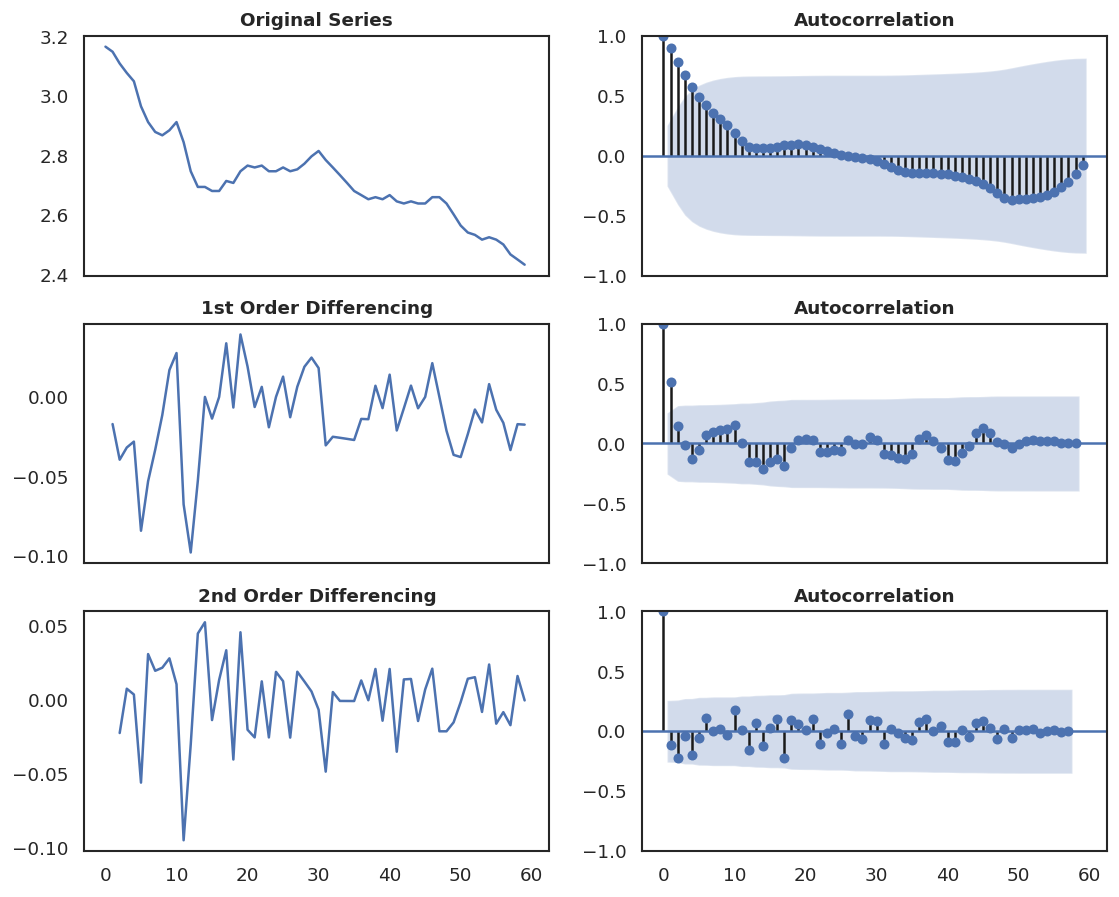

In [ ]:
plt.rcParams.update({'figure.figsize':(11,9), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=True)

# Original Series
axes[0, 0].plot(AB_log_1['birth rate']); 
axes[0, 0].set_title('Original Series',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)
plot_acf(AB_log_1['birth rate'], ax=axes[0, 1],lags=59)
axes[0,1].set_title('Autocorrelation',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)

# 1st Differencing
axes[1, 0].plot(AB_log_1['birth rate'].diff()); 
axes[1, 0].set_title('1st Order Differencing',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)
plot_acf(AB_log_1['birth rate'].diff().dropna(), ax=axes[1, 1],lags=58)
axes[1,1].set_title('Autocorrelation',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)

# 2nd Differencing
axes[2, 0].plot(AB_log_1['birth rate'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)
plot_acf(AB_log_1['birth rate'].diff().diff().dropna(), ax=axes[2, 1],lags=57)
axes[2,1].set_title('Autocorrelation',
             fontdict= { 'fontsize': 11, 'fontweight':'bold'},
             y =1)
plt.show()





It can be seen that the tailing order of the acf graph of the original sequence was too high, and the truncation order after the second-order difference was too small, so the first-order difference was more suitable. That means, **the differencing order of our model was 1**.

### 2.3.2 The Order of the AR Term(p) and MA Term(q)

We can use ACF to determine the optimal number of MA terms and PACF to determine the optimal number of AR terms. Those two numbers of terms determine the oreder of the model. Here we plot the outcome of ACF and PACF. The blue shaded areas represent the significance thresholds, and vertical lines represent the ACF and PACF values. Only those vertical lines beyond the significane thresholds are significant.

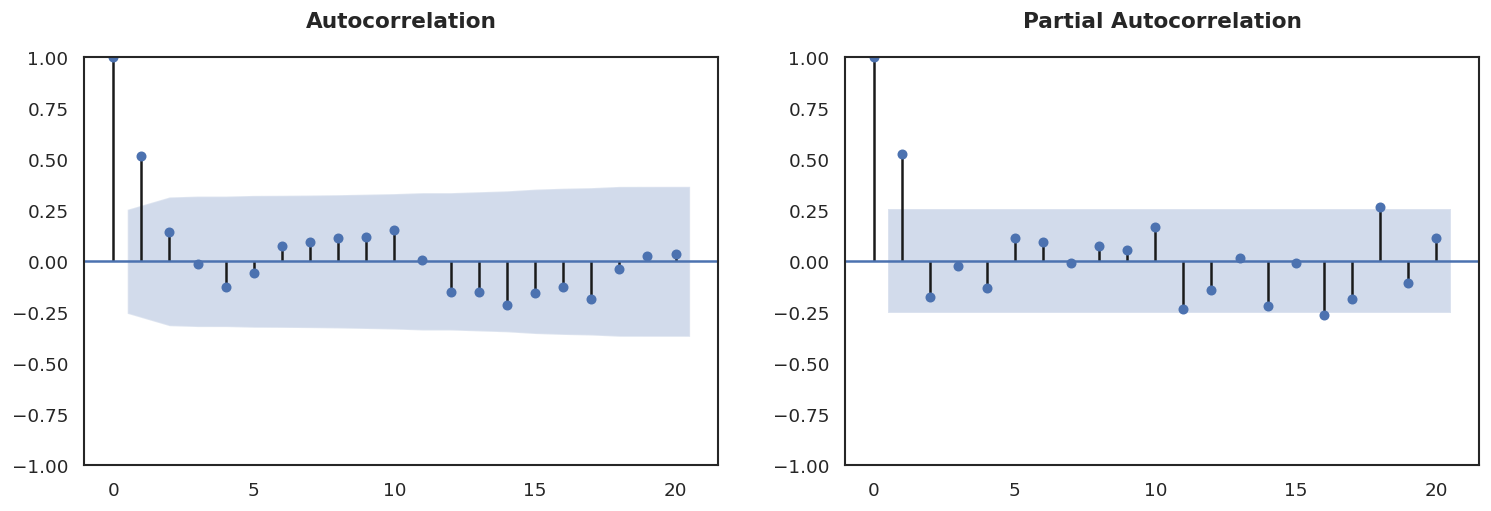

In [ ]:
# 1st Differencing
plt.rcParams.update({'figure.figsize':(15,4.5), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(AB_log['birth rate'].diff().dropna(),ax=axes[0],lags=20)
plot_pacf(AB_log['birth rate'].diff().dropna(),ax=axes[1],lags=20) 

axes[0].set_title('Autocorrelation',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)
axes[1].set_title('Partial Autocorrelation',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)

plt.show()

**Based on the plots above, we can speculate that p is almost 0 and q is 1 or 2.**

### 2.3.3 Training and Testing the Model

Although we can get the order of the Arima model with ACF and PACF above, we can also train the model with pmdarima package, by which we can specify an upper order limit and an information criterion calculation method to find the order combination with the smallest information criterion. Here we chose AIC as the smallest information criterion. The upper order limits of q and q were both 2.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

We made the first 2/3 birth rates(1960~1998) as training data, and the last 1/3 birth rates(1999-2019) as testing data. We built an Arima model with auto_arima function and predicted on the testing set.

In [ ]:
size = int(len(AB_log) * 0.66)
train, test = AB_log[0:size], AB_log[size:len(AB_log)]
# 1960 - 1998 training set
# 1999 - 2019 testing set

In [ ]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False)

print(model.summary())

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-153.420, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-165.086, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-163.346, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-162.143, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-163.610, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-163.466, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-161.539, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-159.495, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-163.064, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-162.144, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-159.689, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-160.052, Time=0.35 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-161.087, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-160.338, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-158.354, Time=0.30 sec

Best mode

Based on the outcome of auto_arima function, **the best order of the Arima is (0,1,1)**.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model_1= ARIMA(train, order=(0,1,1), trend="t")
results = model_1.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             birth rate   No. Observations:                   39
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  85.545
Date:                Tue, 03 May 2022   AIC                           -165.091
Time:                        03:39:03   BIC                           -160.178
Sample:                    01-01-1960   HQIC                          -163.343
                         - 01-01-1998                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0129      0.007     -1.824      0.068      -0.027       0.001
ma.L1          0.6128      0.129      4.763      0.000       0.361       0.865
sigma2         0.0006      0.000      5.055      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 4.09
Prob(Q):                              0.67   Prob(JB):                         0.13
Heteroskedasticity (H):               0.26   Skew:                            -0.59
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We can have a look at how the model compares to the original time series. It seems the model performed pretty well.

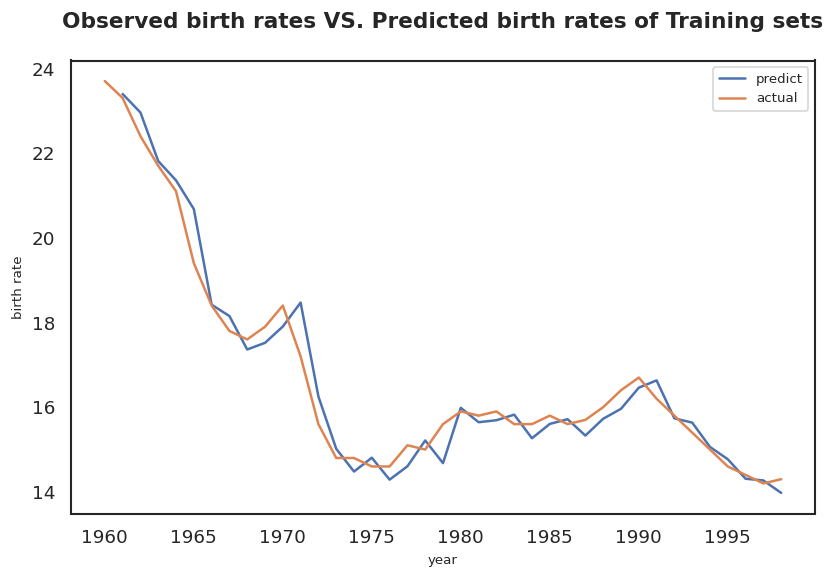

In [ ]:
# predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
# predictions_ARIMA_log = pd.Series(train['birth rate'].iloc[0], index=train.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(results.fittedvalues[1:])

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(predictions_ARIMA,label = 'predict')
plt.plot(np.exp(train),label = 'actual')

plt.legend(loc='upper right', fontsize=8)

plt.xlabel('year',size = 8)
plt.ylabel('birth rate', size = 8)
plt.title('Observed birth rates VS. Predicted birth rates of Training sets', size = 9)
ax.set_title('Observed birth rates VS. Predicted birth rates of Training sets',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)

plt.show()

And let's plot residual errors and their density. The series of residual errors closely follows a random error distribution, indicating it is a good model fit.

<Figure size 1200x600 with 0 Axes>

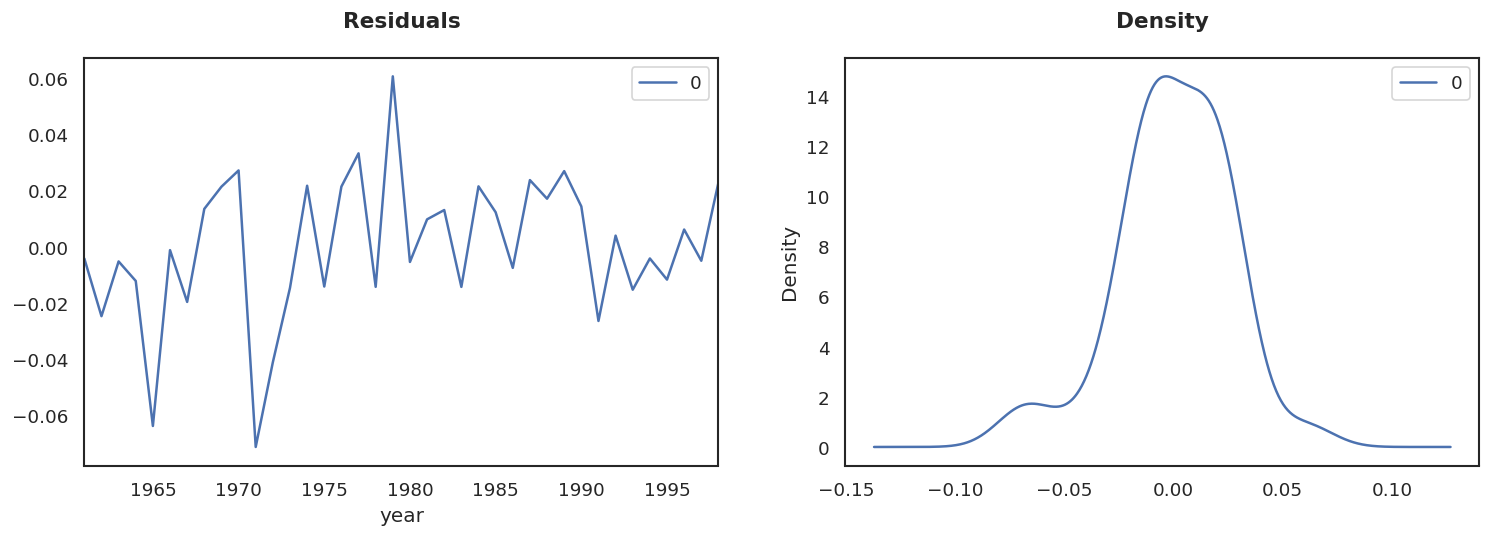

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(results.resid[1:])

plt.figure(figsize=(10, 5))
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
ax[0].set_title('Residuals',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set_title('Density',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)


plt.show()

We can also test wether the residuals is white noise with ljungbox test. The p-value is larger than 0.05, indicating the series of residuals is white noise. **In conclusion, our Arima model with order (0,1,1) was pretty good!**

In [ ]:
sm.stats.acorr_ljungbox(results.resid,lags=[10])

lb_stat  lb_pvalue
10  0.042619        1.0

Let's use the model to predict on testing set, and plot the observed values and predicted values.

In [ ]:
# Forecast
fc = results.forecast(21, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

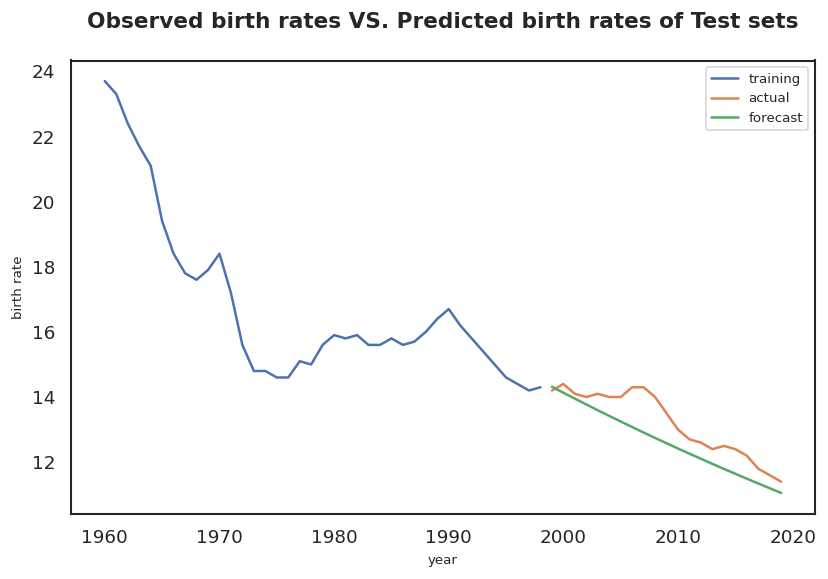

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
predictions_ARIMA_1 = np.exp(fc_series)
#plt.plot(America_birthrate_df, label = 'actual')
#plt.plot(predictions_ARIMA)
plt.plot(np.exp(train),label = 'training')
plt.plot(np.exp(test),label = 'actual')
plt.plot(predictions_ARIMA_1,label = 'forecast')
# plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
#                  color='k', alpha=.15)
plt.xlabel('year',size = 8)
plt.ylabel('birth rate', size = 8)

ax.set_title('Observed birth rates VS. Predicted birth rates of Test sets',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)
plt.legend(loc='upper right', fontsize=8)
plt.show()

And the **RMSE** of the test set is **0.696**.

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(np.exp(test), predictions_ARIMA_1))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.697


## 2.4 Predictions for Birth Rate 20 Years Later

Now we fitted the whole data, and predicted birth rates of  next 20 years.

In [ ]:
model_final = ARIMA(AB_log, order=(0,1,1), trend = 't')
results_final = model_final.fit()

In [ ]:
datetime_20 = pd.date_range('2020-01-01', periods=20, freq='Y')

In [ ]:
# Forecast
fc_final = results_final.forecast(20, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series_final = pd.Series(fc_final)
# lower_series_final = pd.Series(conf_final[:, 0],index = datetime_20)
# upper_series_final = pd.Series(conf_final[:, 1],index = datetime_20)

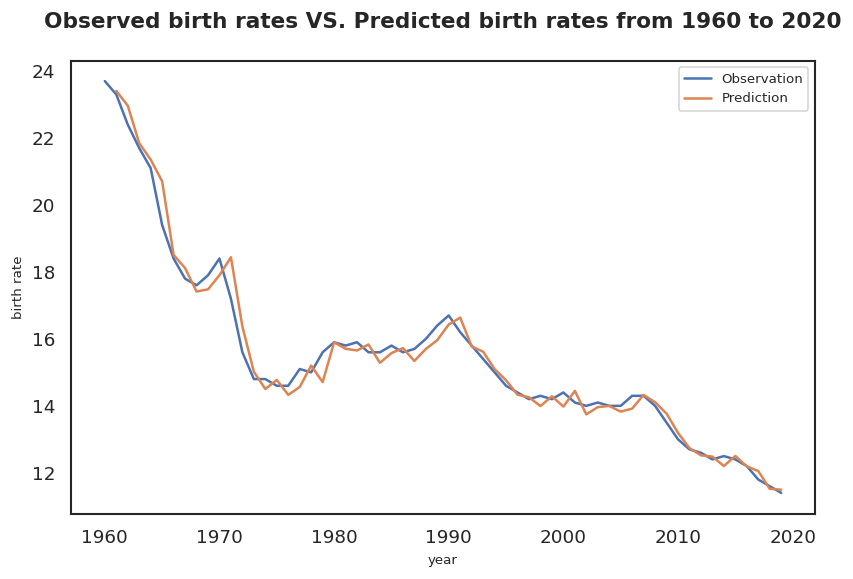

In [ ]:
# predictions_ARIMA_diff_final = pd.Series(results_final.fittedvalues, copy=True)
# predictions_ARIMA_diff_cumsum_final = predictions_ARIMA_diff_final.cumsum()
# predictions_ARIMA_log_final = pd.Series(AB_log['birth rate'].iloc[0], index=AB_log.index)
# predictions_ARIMA_log_final = predictions_ARIMA_log_final.add(predictions_ARIMA_diff_cumsum_final, fill_value=0)
predictions_ARIMA_final = np.exp(results_final.fittedvalues[1:])

fig, ax = plt.subplots(figsize=(8, 5))
plt.xlabel('year',size = 8)
plt.ylabel('birth rate', size = 8)

ax.set_title('Observed birth rates VS. Predicted birth rates from 1960 to 2020',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)

plt.plot(America_birthrate_df, label = 'Observation')
plt.plot(predictions_ARIMA_final, label = 'Prediction')

plt.legend(loc='upper right', fontsize=8)

plt.show()

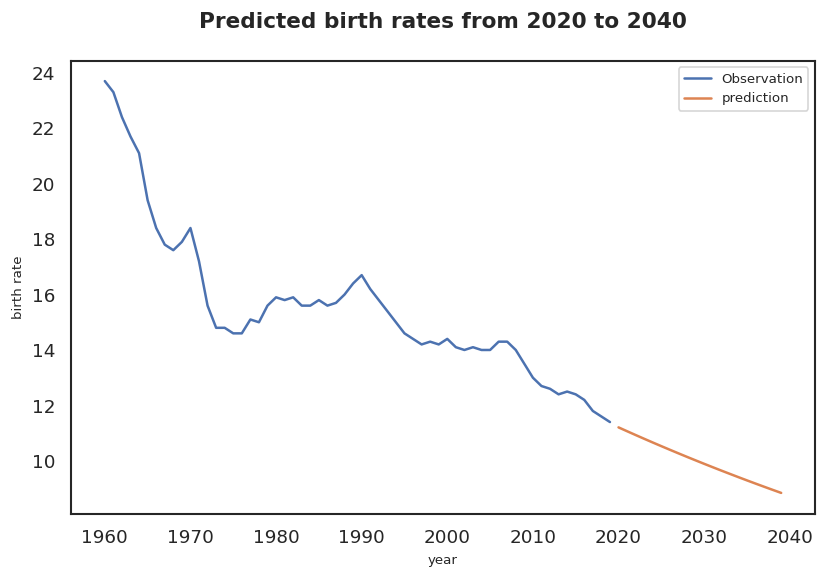

In [ ]:
predictions_ARIMA_predic = np.exp(fc_series_final)

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(America_birthrate_df, label = 'Observation')
plt.plot(predictions_ARIMA_predic, label = 'prediction')

plt.xlabel('year',size = 8)
plt.ylabel('birth rate', size = 8)
plt.legend(loc='upper right', fontsize=8)
plt.title('Predicted birth rates from 2020 to 2040', size = 9)
ax.set_title('Predicted birth rates from 2020 to 2040',
             fontdict= { 'fontsize': 13, 'fontweight':'bold'},
             y =1.05)

plt.show()

**According to our model, the birth rate of America will continue to decline over the next two decades, and it will drop to 8.85% by 2039.**

# 3.Conclusion

In 2039, United States will become an **aged country** and its birth rate will drop to **8.85%**.
According to the prediction of population aging and birth rate, governments are able to put forward reasonable policies to respond to the lack of medical resources and economic stagnation in the future or even slow down the aging of the population.

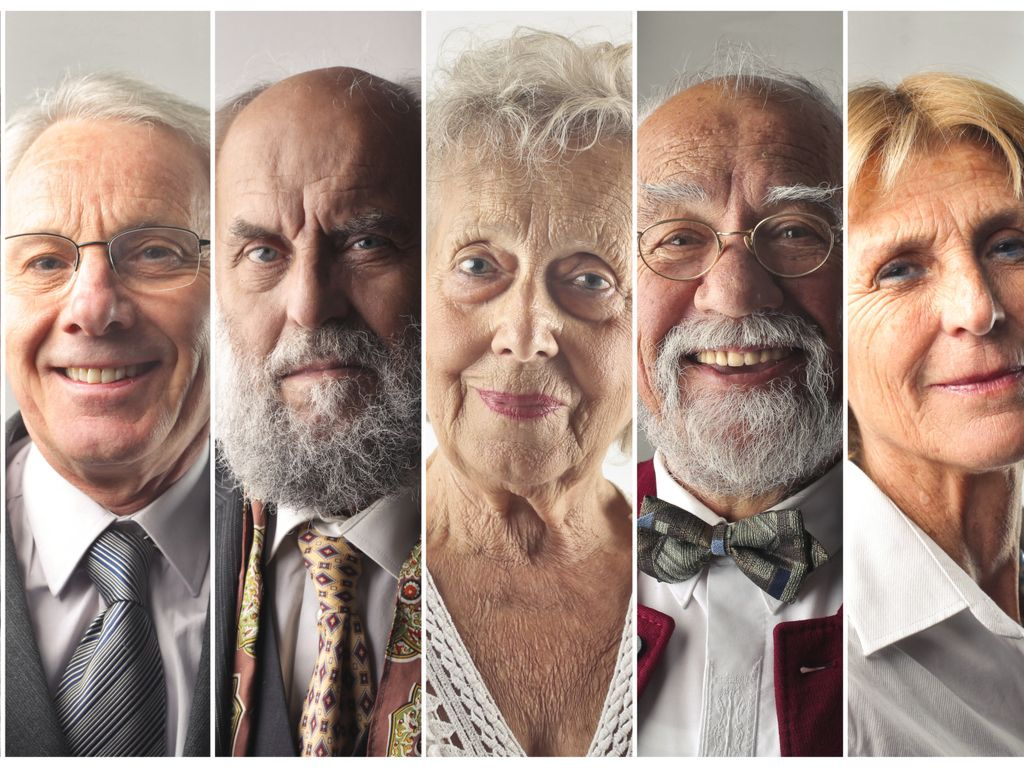